# Experimentación - DryGrEncoder



## 1. Obtención de datos



In [1]:
import torch
print(torch.__version__)

2.3.0


In [2]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [23]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [114]:
results_save_path = "./results"
name_model = "DryGrEncoder"

In [24]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:  row_132
Processing: 

## Funciones auxiliares - entrenamiento

In [25]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from utils.dygrae import DyGrEncoder
from sklearn.metrics import r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot
from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerModel
from utils import trainer
dtype = torch.float
device = torch.device("mps")

In [26]:
from importlib import reload  # Python 3.4+
import utils.dygrae
dygrae = reload(utils.dygrae)


In [78]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target, num_conv=1,  num_lstm=1, aggr="mean"):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        super(RecurrentGCN, self).__init__()
        self.recurrent = dygrae.DyGrEncoder(conv_out_channels=100, conv_num_layers=num_conv, conv_aggr=aggr, lstm_out_channels=self.n_features, lstm_num_layers=num_lstm)
        self.linear = torch.nn.Linear(self.n_features, n_target)
        self.h =None

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h, h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h)
        h = self.linear(h)
        self.h = h
        return h, h_0, c_0


In [103]:
def eval(model, dataloader, h):
    model.eval()
    loss_eval, r2_eval = [], []
    h, c = None, None
    for time, snapshot in enumerate(dataloader['val']):
        x = snapshot.x.to(device)  # [num_nodes, num_time_steps] -> [23, 100]
        edge_index = snapshot.edge_index.permute(2, 1, 0).to(device)  # [2, num_edges, num_time_steps]-> [2, 30, 100]
        edge_attr = snapshot.edge_attr.permute(1, 0, 2).to(device)  # [num_edges, num_time_steps, num_edge_features] -> [30, 100, 2]
        y = snapshot.y.to(device)

        y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
        loss = F.mse_loss(y_hat, y).item()
        r2_eval.append(r2_score(y.cpu(), y_hat.cpu()))
        loss_eval.append(loss)
    return loss_eval, r2_eval




def train(model,dataloader, num_early_stop, num_epochs, lr, device= torch.device("cpu")):

    print("\n==================== TRAIN INFO ===================\n")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    lr_schedule = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=0.001)
    early_stop_counter = 0
    best_eval_r2score = -100.0
    best_eval_loss = float('inf')
    losses = []
    eval_losses, r2scores = [], []
    is_best = False

    for epoch in range(num_epochs):
        model.train()
        cost = 0
        h,c=None, None
        for time, snapshot in enumerate(dataloader['train']):
            x = snapshot.x.to(device)  # Mover a GPU
            edge_index = snapshot.edge_index.permute(2, 1, 0).to(device)  # Mover a GPU
            edge_attr = snapshot.edge_attr.permute(1, 0, 2).to(device)  # Mover a GPU
            y = snapshot.y.to(device)  # Mover a GPU

            y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
            cost = cost + F.mse_loss(y_hat, y)
        
        cost = cost / (time+1)
        cost.backward(retain_graph=False)
        losses.append(cost.item())
        optimizer.step()
        optimizer.zero_grad()
            
        train_loss = cost

    
        with torch.no_grad():
            e_loss_batch, r2_loss_batch = eval(model, dataloader, h)
            eval_loss = torch.FloatTensor(e_loss_batch).mean().item()
            eval_r2score = torch.FloatTensor(r2_loss_batch).mean().item()
            eval_losses.append(e_loss_batch)
            r2scores.append(r2_loss_batch)
        
        print(f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Eval Loss: {eval_loss:.4f} | "
            f"Eval R2: {eval_r2score:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if num_early_stop > 0:
            if eval_loss <= best_eval_loss:
                best_eval_loss = eval_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            if epoch > num_epochs / 2 and early_stop_counter > num_early_stop:
                print("Early stopping triggered.")
                break
            
        if lr_schedule:
            lr_schedule.step(eval_loss)

        if best_eval_r2score < eval_r2score:
            is_best = True
            best_eval_r2score = eval_r2score
        recording = {"epoch": epoch, "is_best": str(is_best)}
    print("\nTraining completed.")
    return losses, eval_losses, r2scores, h
    


def test(model, dataloader, h, save_predictions=True):
    
    print("\n==================== TEST INFO ===================\n")
    
    model.eval()
    predictions = []
    real =[]
    losses_tst, r2score_tst, loss_nodes = [], [], []
    h,c=None, None
    for time, snapshot in enumerate(dataloader['test']):
        x = snapshot.x.to(device)  # [num_nodes, num_time_steps] -> [23, 100]
        edge_index = snapshot.edge_index.permute(2, 1, 0).to(device)  # [2, num_edges, num_time_steps]-> [2, 30, 100]
        edge_attr = snapshot.edge_attr.permute(1, 0, 2).to(device)  # [num_edges, num_time_steps, num_edge_features] -> [30, 100, 2]
        y = snapshot.y.to(device)

        y_hat, h, c = model(x, edge_index[:,:,0],edge_attr, h, c)
        loss = F.mse_loss(y_hat, y).item()

        loss_per_node = F.mse_loss(y_hat, y, reduction='none').mean(dim=1).cpu().detach().numpy()
        loss_nodes.append(loss_per_node)
        preds = y_hat.view(model.n_nodes, model.n_target)
        r2score_tst.append(r2_score(y.detach().cpu(), y_hat.detach().cpu()))
        losses_tst.append(loss)
        if save_predictions:
            real.append(y.view(model.n_nodes, model.n_target).cpu().detach().numpy())
            predictions.append(preds.cpu().detach().numpy())

        
    test_loss = torch.tensor(losses_tst).mean().item()
    test_r2score = np.mean(r2score_tst)

    print(f"Test_loss:{test_loss:.4f}, Test_r2:{test_r2score:.4f}")
    return r2score_tst, losses_tst, loss_nodes, predictions, real

In [122]:
import itertools


def entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader, num_early_stop, num_epochs, lr):
    """
    Entrena y evalúa modelos con diferentes combinaciones de hiperparámetros, y devuelve el mejor modelo,
    los mejores parámetros y un DataFrame con los resultados.

    Args:
        param_grid (dict): Diccionario con listas de valores de los hiperparámetros a probar.
        n_features (int): Número de características del nodo.
        n_nodes (int): Número de nodos.
        n_target (int): Número de objetivos.
        dataloader (object): Objeto que proporciona los datos para entrenamiento y evaluación.
        num_early_stop (int): Número de épocas para detenerse tempranamente si no hay mejora.
        num_epochs (int): Número de épocas para entrenar.
        lr (float): Tasa de aprendizaje.

    Returns:
        mejor_modelo (object): El mejor modelo entrenado.
        mejores_parametros (tuple): Los mejores parámetros (aggr, conv, lstm).
        resultados_gt (pd.DataFrame): DataFrame con los resultados de todas las combinaciones de hiperparámetros.
    """
    resultados_list = []

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_modelo = None
    mejores_parametros = None
    mejor_h = None
    mejores_resultados = None

    device =torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for aggr, conv, lstm in tqdm(list(itertools.product(param_grid["aggr"], param_grid["conv"], param_grid["lstm"]))):
        model = RecurrentGCN("DyGrEncoder", node_features=n_features, node_count=n_nodes, n_target=n_target, num_conv=conv, num_lstm=lstm, aggr=aggr)
        losses, eval_losses, r2scores, h = train(model, dataloader, num_early_stop, num_epochs, lr, device=device)
        r2score_tst, losses_tst,loss_nodes, _, _ = test(model, dataloader, h, save_predictions=False)

        results_intermedio = {
            "Aggr": aggr,
            "Conv": conv,
            "LSTM": lstm,
            "loss_final": losses[-1],
            "r2_eval_final": np.mean(r2scores[-1]),
            "loss_eval_final": np.mean(eval_losses[-1]),
            "r2_test": np.mean(r2score_tst),
            "loss_test": np.mean(losses_tst),
            "loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        # Añade los resultados a la lista
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_modelo = model
            mejores_parametros = (aggr, conv, lstm)
            mejor_h = h
            mejores_resultados = results_intermedio

        print("Parámetros: ", aggr, conv, lstm)
        print("Resultados: ", resultados_list[-1])

    resultados_gt = pd.DataFrame(resultados_list)

    return mejor_modelo, mejores_parametros, mejores_resultados, resultados_gt, mejor_h


## Prueba - predicción por tipos

### Gen trip

In [33]:
problem = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [34]:
n_div_gt = loader.div

#### Sencilla 

In [35]:
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0902 | Eval Loss: 0.6045 | Eval R2: -282.9975 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5943 | Eval Loss: 0.1254 | Eval R2: -44.3431 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1300 | Eval Loss: 0.1823 | Eval R2: -85.4093 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1964 | Eval Loss: 0.1231 | Eval R2: -51.8920 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1338 | Eval Loss: 0.0808 | Eval R2: -25.2032 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0870 | Eval Loss: 0.1011 | Eval R2: -32.9455 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1038 | Eval Loss: 0.1120 | Eval R2: -38.0702 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.1135 | Eval Loss: 0.0928 | Eval R2: -28.8036 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0946 | Eval Loss: 0.0895 | Eval R2: -27.2487 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0914 | Eval Loss

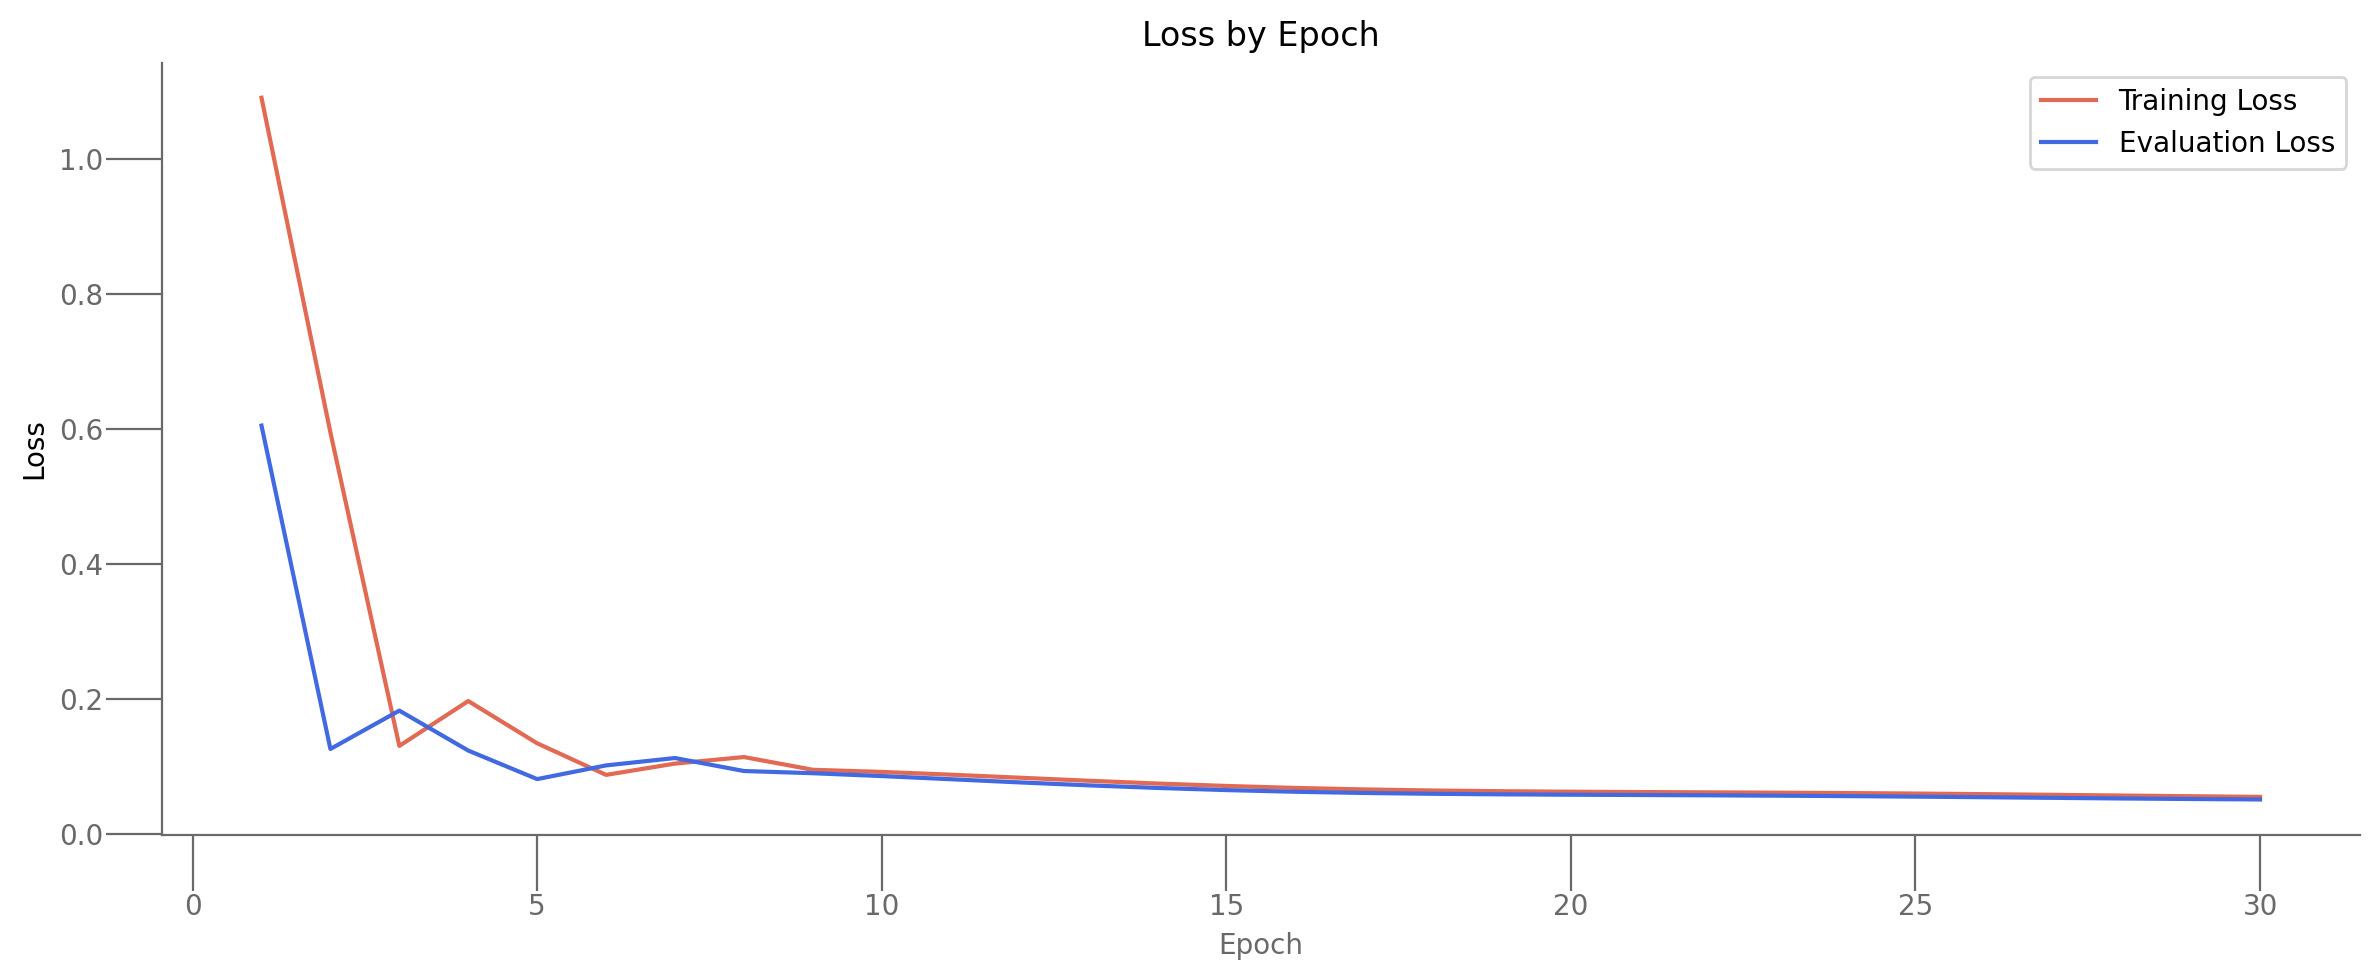


==================== TEST INFO ===================

Test_loss:0.0401, Test_r2:-14.1714


In [48]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}
dataloader_gt = trainer.train_test_val_split(dataset_gt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])


num_early_stop = 0
num_epochs = 30
lr = 0.01

model = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=1, num_lstm=1, aggr="add")

losses,eval_losses, r2scores, h = train(model, dataloader_gt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = test(model, dataloader_gt, h)


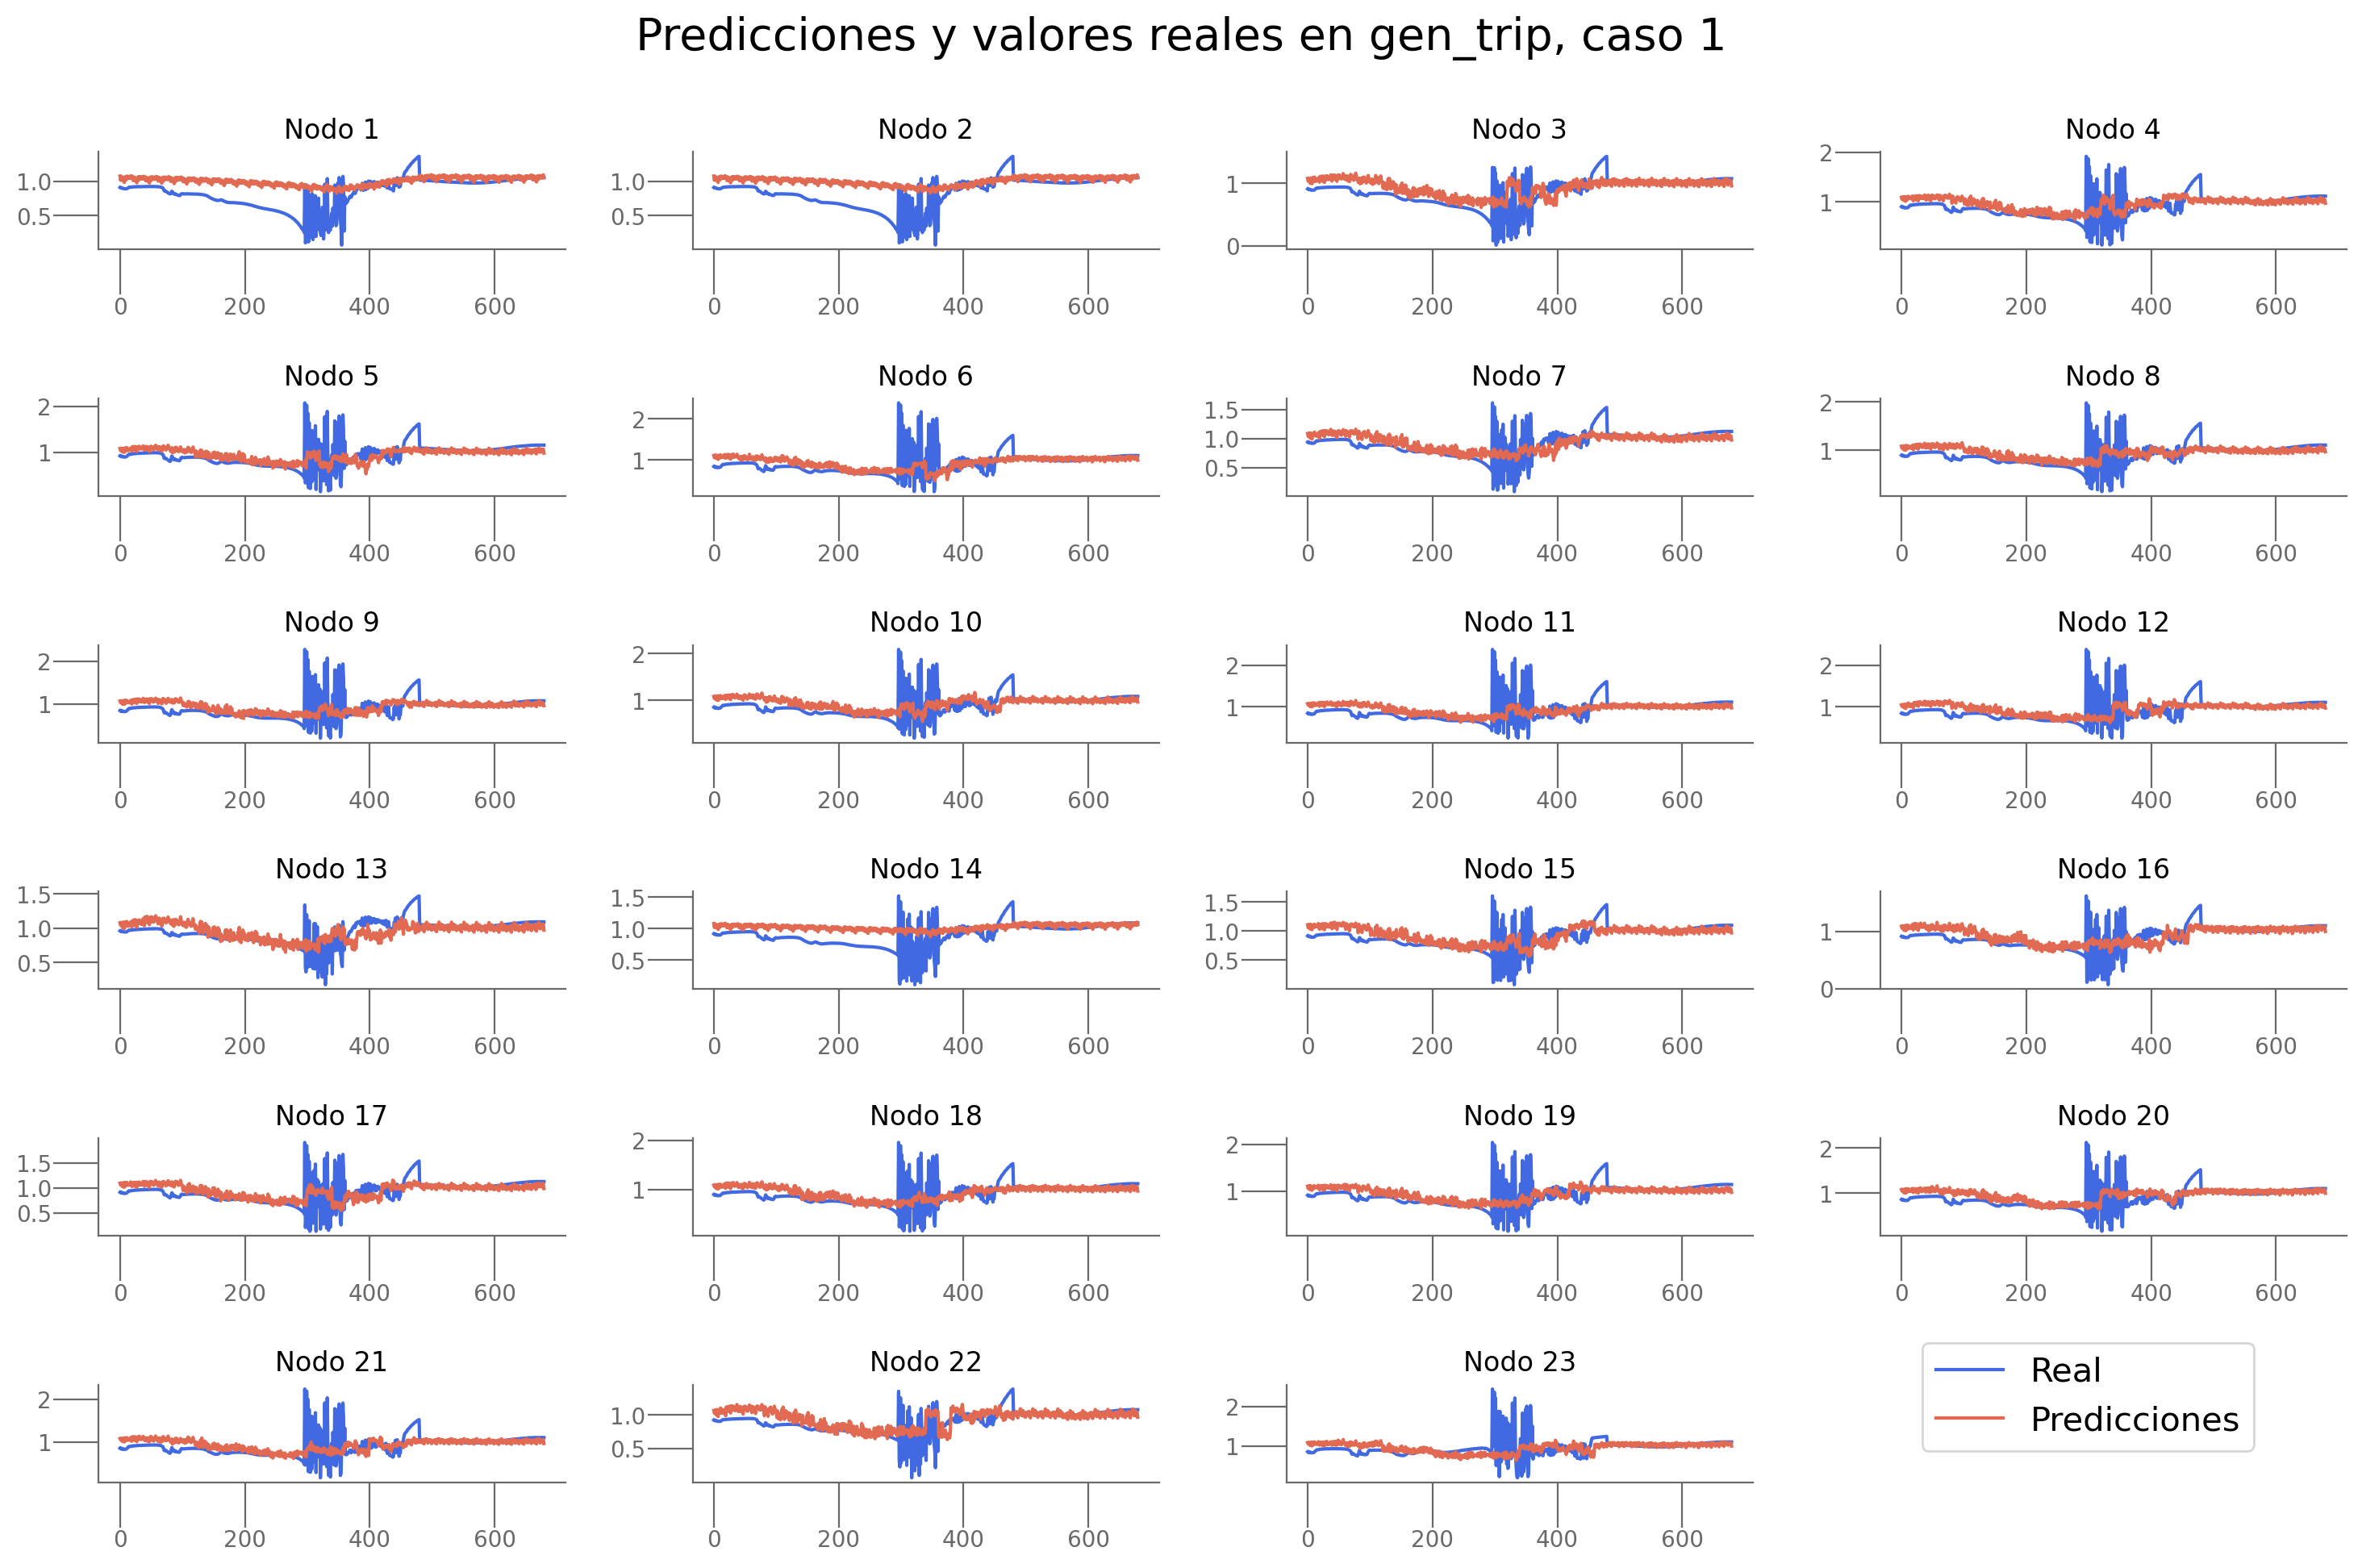

In [49]:
plot_predictions(predictions, real, n_target, 1, n_div_gt, problem)

#### Ajuste de parámetros 

In [123]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_gt,params_gt, resultados_final_gt, resultados_gt, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_gt, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.2102 | Eval Loss: 0.6467 | Eval R2: -302.0855 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6367 | Eval Loss: 0.1649 | Eval R2: -62.0415 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1668 | Eval Loss: 0.1794 | Eval R2: -83.2962 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1920 | Eval Loss: 0.1347 | Eval R2: -59.1787 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1456 | Eval Loss: 0.0854 | Eval R2: -29.7565 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0930 | Eval Loss: 0.0802 | Eval R2: -24.5977 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0852 | Eval Loss: 0.0945 | Eval R2: -30.8067 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0974 | Eval Loss: 0.0985 | Eval R2: -32.7918 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.1005 | Eval Loss: 0.0873 | Eval R2: -27.5167 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0893 | Eval Loss: 0.0854 | Eval R2: -26.5856 | LR: 0.001000
Epoch 11/30 | Train Loss: 0.0874 | Eval Loss: 0.0828 | Eval R2: -25.3545 |

 12%|█▎        | 1/8 [19:39<2:17:38, 1179.74s/it]

Test_loss:0.0411, Test_r2:-14.4254
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.0539621002972126, 'r2_eval_final': -12.565533488077008, 'loss_eval_final': 0.05035443146905852, 'r2_test': -14.425381882399714, 'loss_test': 0.0411445792982426, 'loss_nodes': [0.05015013366937637, 0.0494048036634922, 0.03975518420338631, 0.04450570419430733, 0.050516411662101746, 0.04772716760635376, 0.03936566039919853, 0.04340211674571037, 0.04619242995977402, 0.04101666063070297, 0.04729728773236275, 0.041783273220062256, 0.025252006947994232, 0.04168449714779854, 0.035393524914979935, 0.03394622728228569, 0.04136982560157776, 0.04120299965143204, 0.048429351300001144, 0.0416962094604969, 0.04102526232600212, 0.029158717021346092, 0.02604999952018261]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1332 | Eval Loss: 0.7780 | Eval R2: -374.5797 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7684 | Eval Loss: 0.2507 | Eval R2: -105.435

 25%|██▌       | 2/8 [39:05<1:57:10, 1171.70s/it]

Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.08843062818050385, 'r2_eval_final': -20.790859881862062, 'loss_eval_final': 0.0807814595111776, 'r2_test': -23.692536960124624, 'loss_test': 0.06660197608246055, 'loss_nodes': [0.07851915806531906, 0.07731927931308746, 0.0728904977440834, 0.07193688303232193, 0.07757087051868439, 0.07542542368173599, 0.06556341797113419, 0.07280200719833374, 0.07619976997375488, 0.06975553184747696, 0.07440061122179031, 0.06749420613050461, 0.04350747913122177, 0.05656387656927109, 0.058367740362882614, 0.058765657246112823, 0.06828971952199936, 0.06721396744251251, 0.07406868785619736, 0.06761825829744339, 0.06713517010211945, 0.049998294562101364, 0.04043906554579735]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1809 | Eval Loss: 0.8607 | Eval R2: -412.2791 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.8435 | Eval Loss: 0.2195 | Eval R2: -86.0789 | LR: 0.010000
Epoch 3/30 | Train L

 38%|███▊      | 3/8 [1:06:56<1:56:37, 1399.52s/it]

Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.05049031972885132, 'r2_eval_final': -12.965572538628463, 'loss_eval_final': 0.04835524222042452, 'r2_test': -14.380696104099458, 'loss_test': 0.039184571528558136, 'loss_nodes': [0.048663027584552765, 0.047917261719703674, 0.03858101740479469, 0.04210236668586731, 0.04628278315067291, 0.04477003589272499, 0.03736962750554085, 0.0410178042948246, 0.042893145233392715, 0.0371713787317276, 0.04342798516154289, 0.039288997650146484, 0.024530382826924324, 0.04095984995365143, 0.034931693226099014, 0.03365672007203102, 0.040664102882146835, 0.03802157938480377, 0.04755733907222748, 0.0389740951359272, 0.03839205950498581, 0.028804151341319084, 0.02526778355240822]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1315 | Eval Loss: 0.8983 | Eval R2: -436.9440 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.8818 | Eval Loss: 0.2145 | Eval R2: -85.2423 | LR: 0.010000
Epoch 3/30 | Tr

 50%|█████     | 4/8 [1:44:27<1:55:42, 1735.71s/it]

Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.08510350435972214, 'r2_eval_final': -19.91750722471289, 'loss_eval_final': 0.077886325772351, 'r2_test': -22.705869084976094, 'loss_test': 0.0642347290025403, 'loss_nodes': [0.076063372194767, 0.07495023310184479, 0.06983984261751175, 0.06925766915082932, 0.07501386851072311, 0.07263866811990738, 0.06300217658281326, 0.0698910504579544, 0.07328895479440689, 0.06671476364135742, 0.07186471670866013, 0.06510602682828903, 0.04137919098138809, 0.05566111579537392, 0.057047586888074875, 0.056083232164382935, 0.06590338796377182, 0.06452163308858871, 0.07205910235643387, 0.06497886031866074, 0.06463415175676346, 0.048729028552770615, 0.0387704037129879]}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.1293 | Eval Loss: 0.5422 | Eval R2: -249.2195 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5331 | Eval Loss: 0.1549 | Eval R2: -64.0027 | LR: 0.010000
Epoch 3/30 | Train Loss: 0

In [120]:
path_save_experiment_gt = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [ ]:

def guardar_resultados(modelo, name_modelo, problem, resultados_mejor_modelo, results_path = "./results",path_save_experiment=None, params_gt=None):
    
    print("\n==================== GUARDANDO RESULTADOS ===================\n")
    path_model = results_path+f"/{problem}"+ f"/{name_modelo}.pt"
    torch.save(modelo.state_dict(), path_model)


    resultados_general_save = {"Modelo": name_modelo, 
                            "Params": params_gt, 
                           "Fichero_resultados_experimento": path_save_experiment, 
                            "Loss_tst": resultados_mejor_modelo["loss_test"],
                            "R2_tst": resultados_mejor_modelo["r2_test"],
                            "Loss_nodes": resultados_mejor_modelo["loss_nodes"],
                            "R2_eval": resultados_mejor_modelo["r2_eval_final"],
                            "Loss_eval": resultados_mejor_modelo["loss_eval_final"],
                            "Loss_final": resultados_mejor_modelo["loss_final"]
                            }


    path_general_problem = results_path+f"/{problem}"+ "/results.csv"

    if os.path.exists(path_general_problem):
        df = pd.read_csv(path_general_problem)
    else:
        # Crear un DataFrame vacío con las columnas del diccionario
        df = pd.DataFrame(columns=resultados_general_save.keys())

    new_data_df = pd.DataFrame([resultados_general_save])

    df = pd.concat([df, new_data_df], ignore_index=True)
    print(df)
    df.to_csv(path_general_problem, index=False)

    print("\n==================== RESULTADOS GUARDADOS ===================\n")



In [ ]:
guardar_resultados(modelo_gt, "DryGrEncoder", problem, resultados_final_gt, results_save_path, path_save_experiment_gt, params_gt)

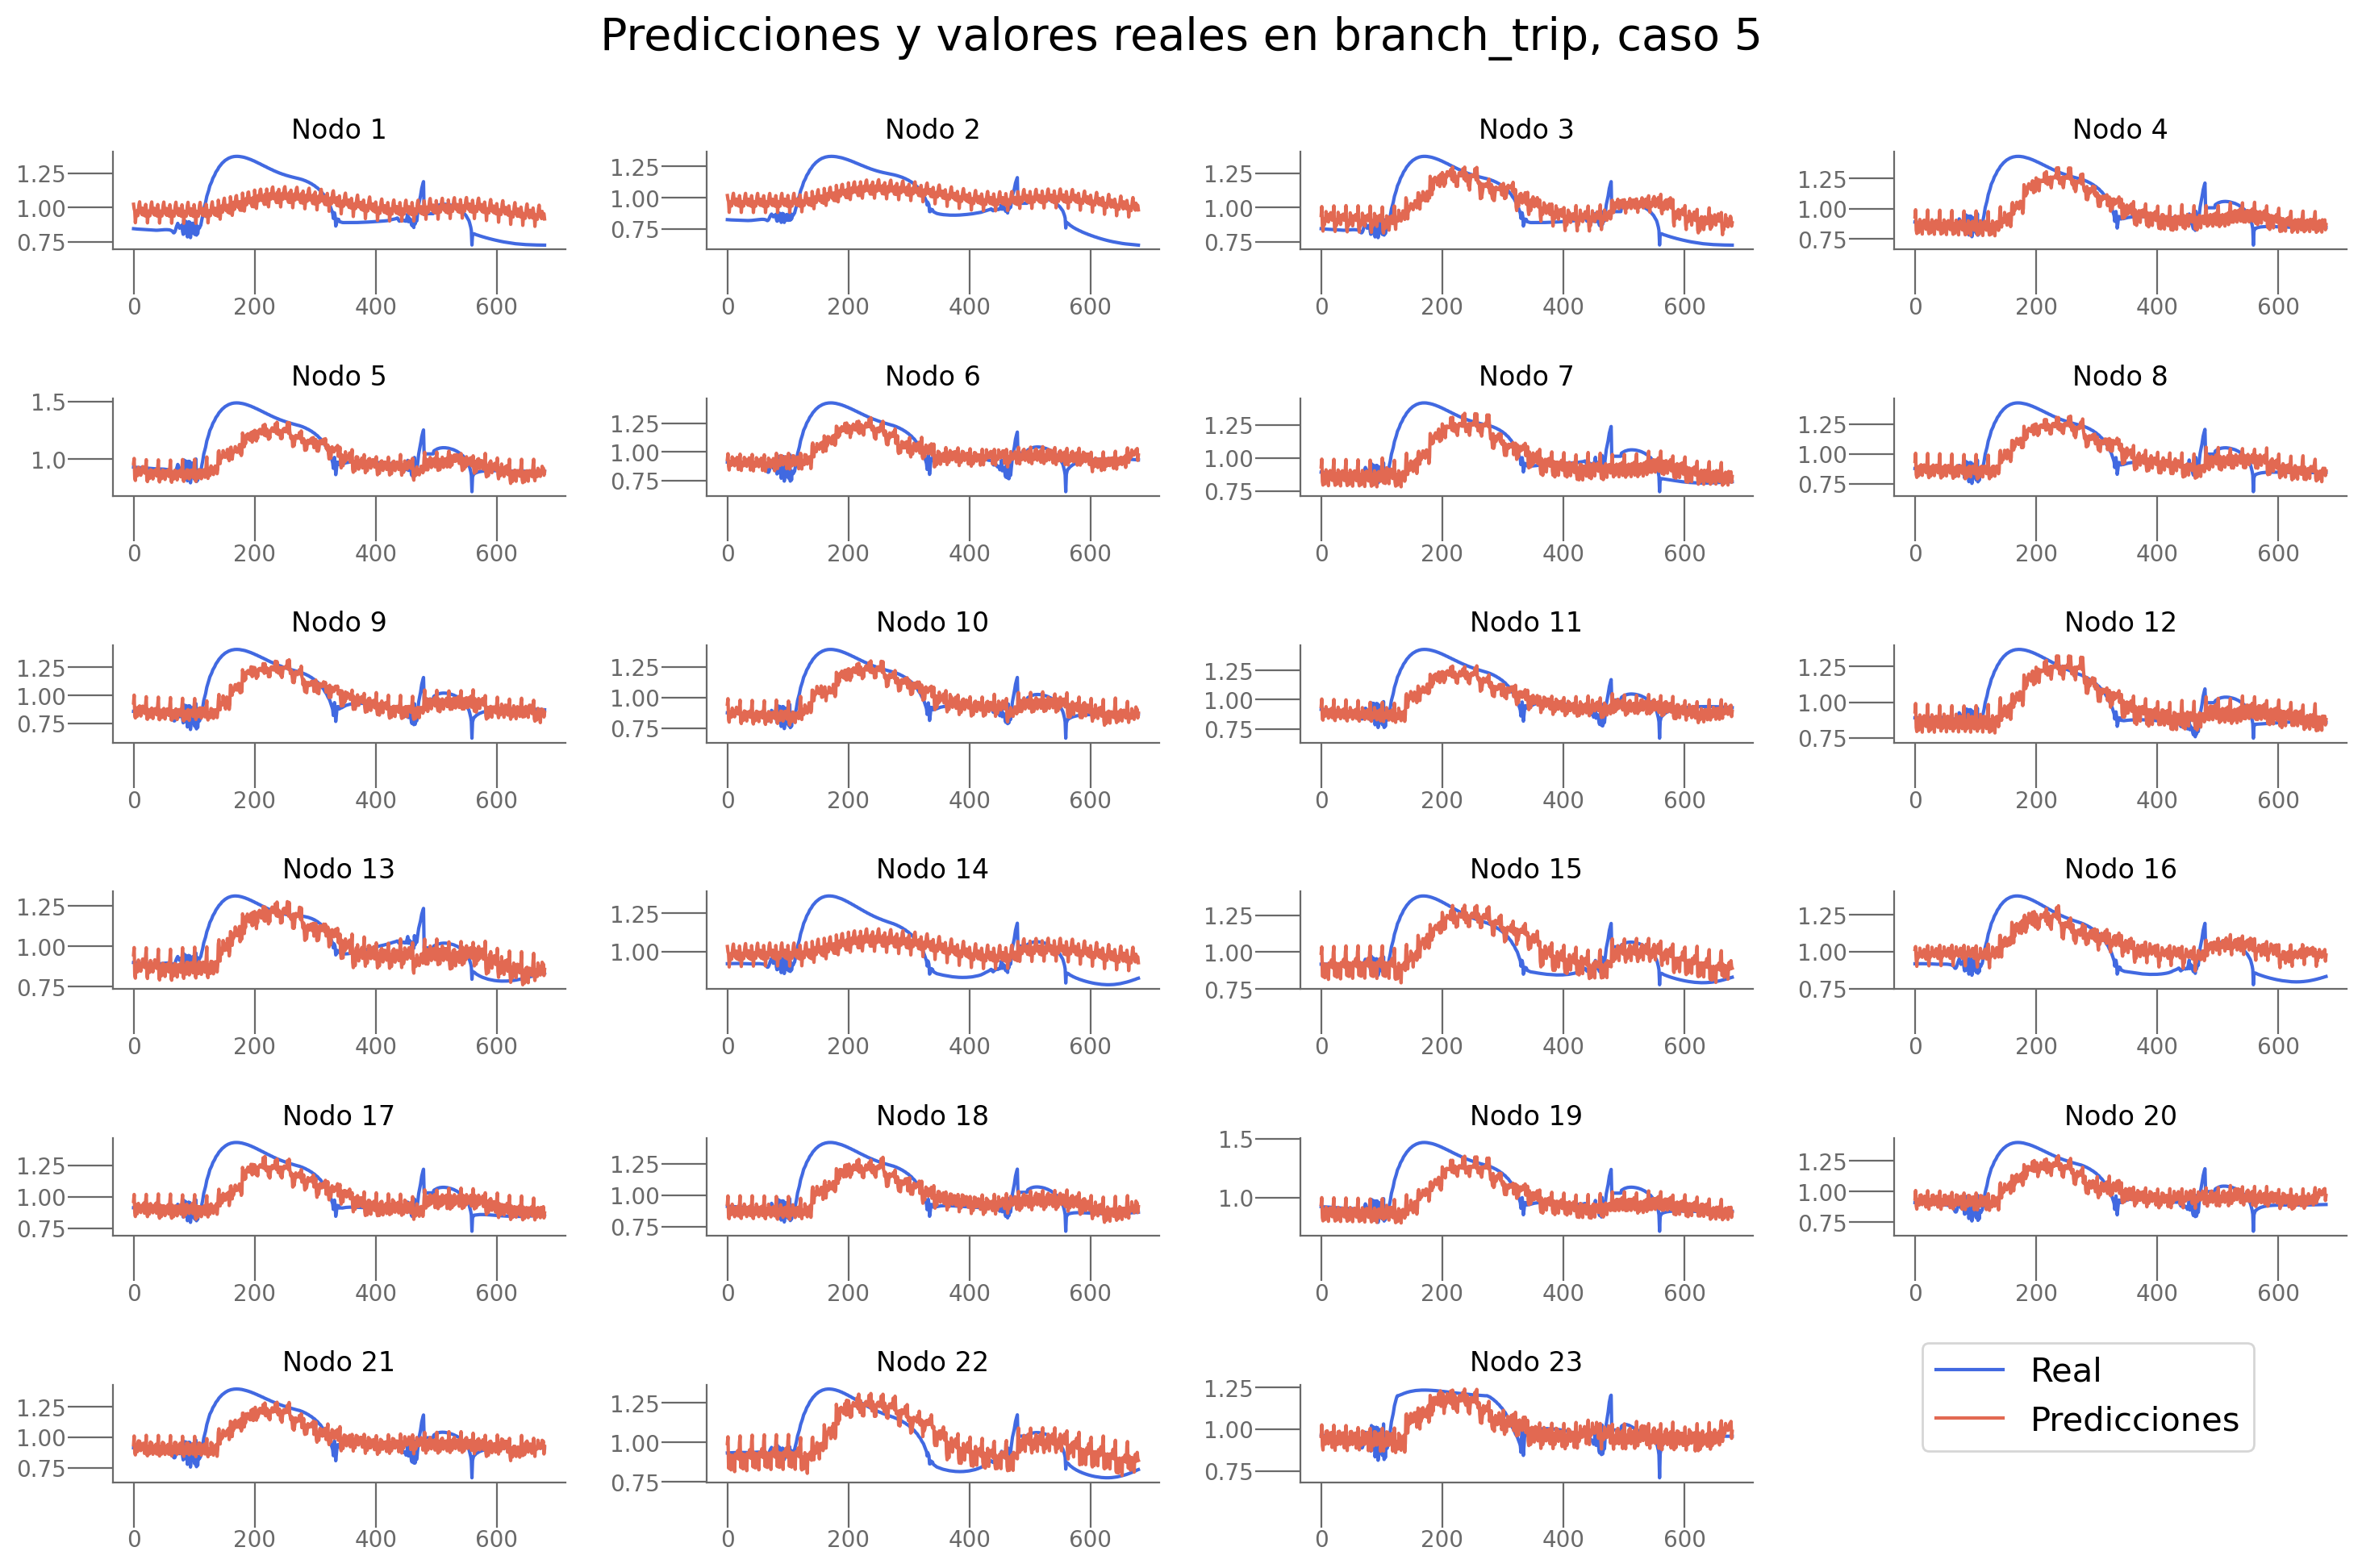

In [87]:
plot_predictions(predictions, real, n_target, 5, n_div_gt, problem)

### Bus trip

In [50]:
problem = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [51]:
n_div_bt = loader.div

#### Sencilla 

In [52]:
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

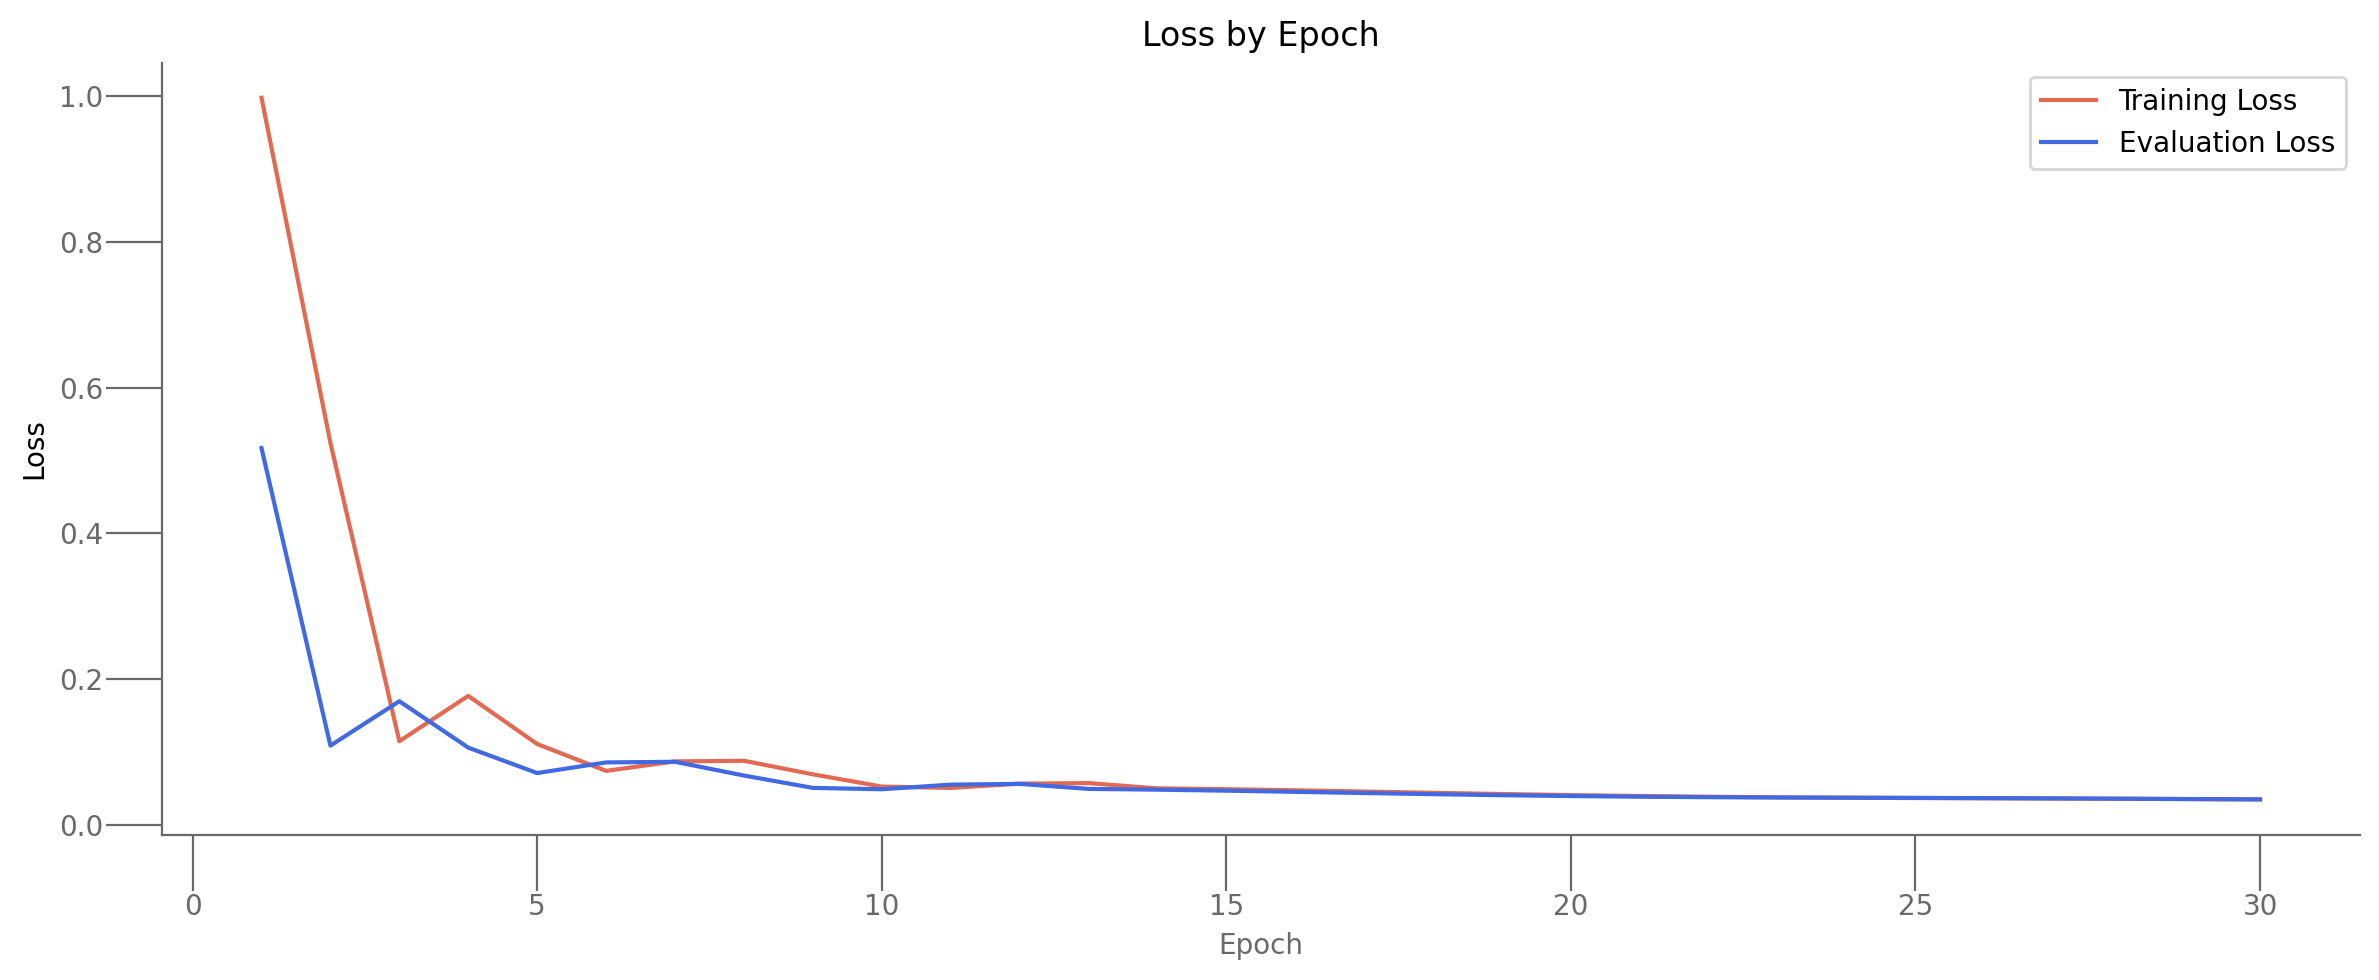


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [53]:

dataloader_bt = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_bt = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")


num_early_stop = 0
num_epochs = 30
lr = 0.01


losses,eval_losses, r2scores, h = train(model_bt, dataloader_bt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = test(model_bt, dataloader_bt, h)


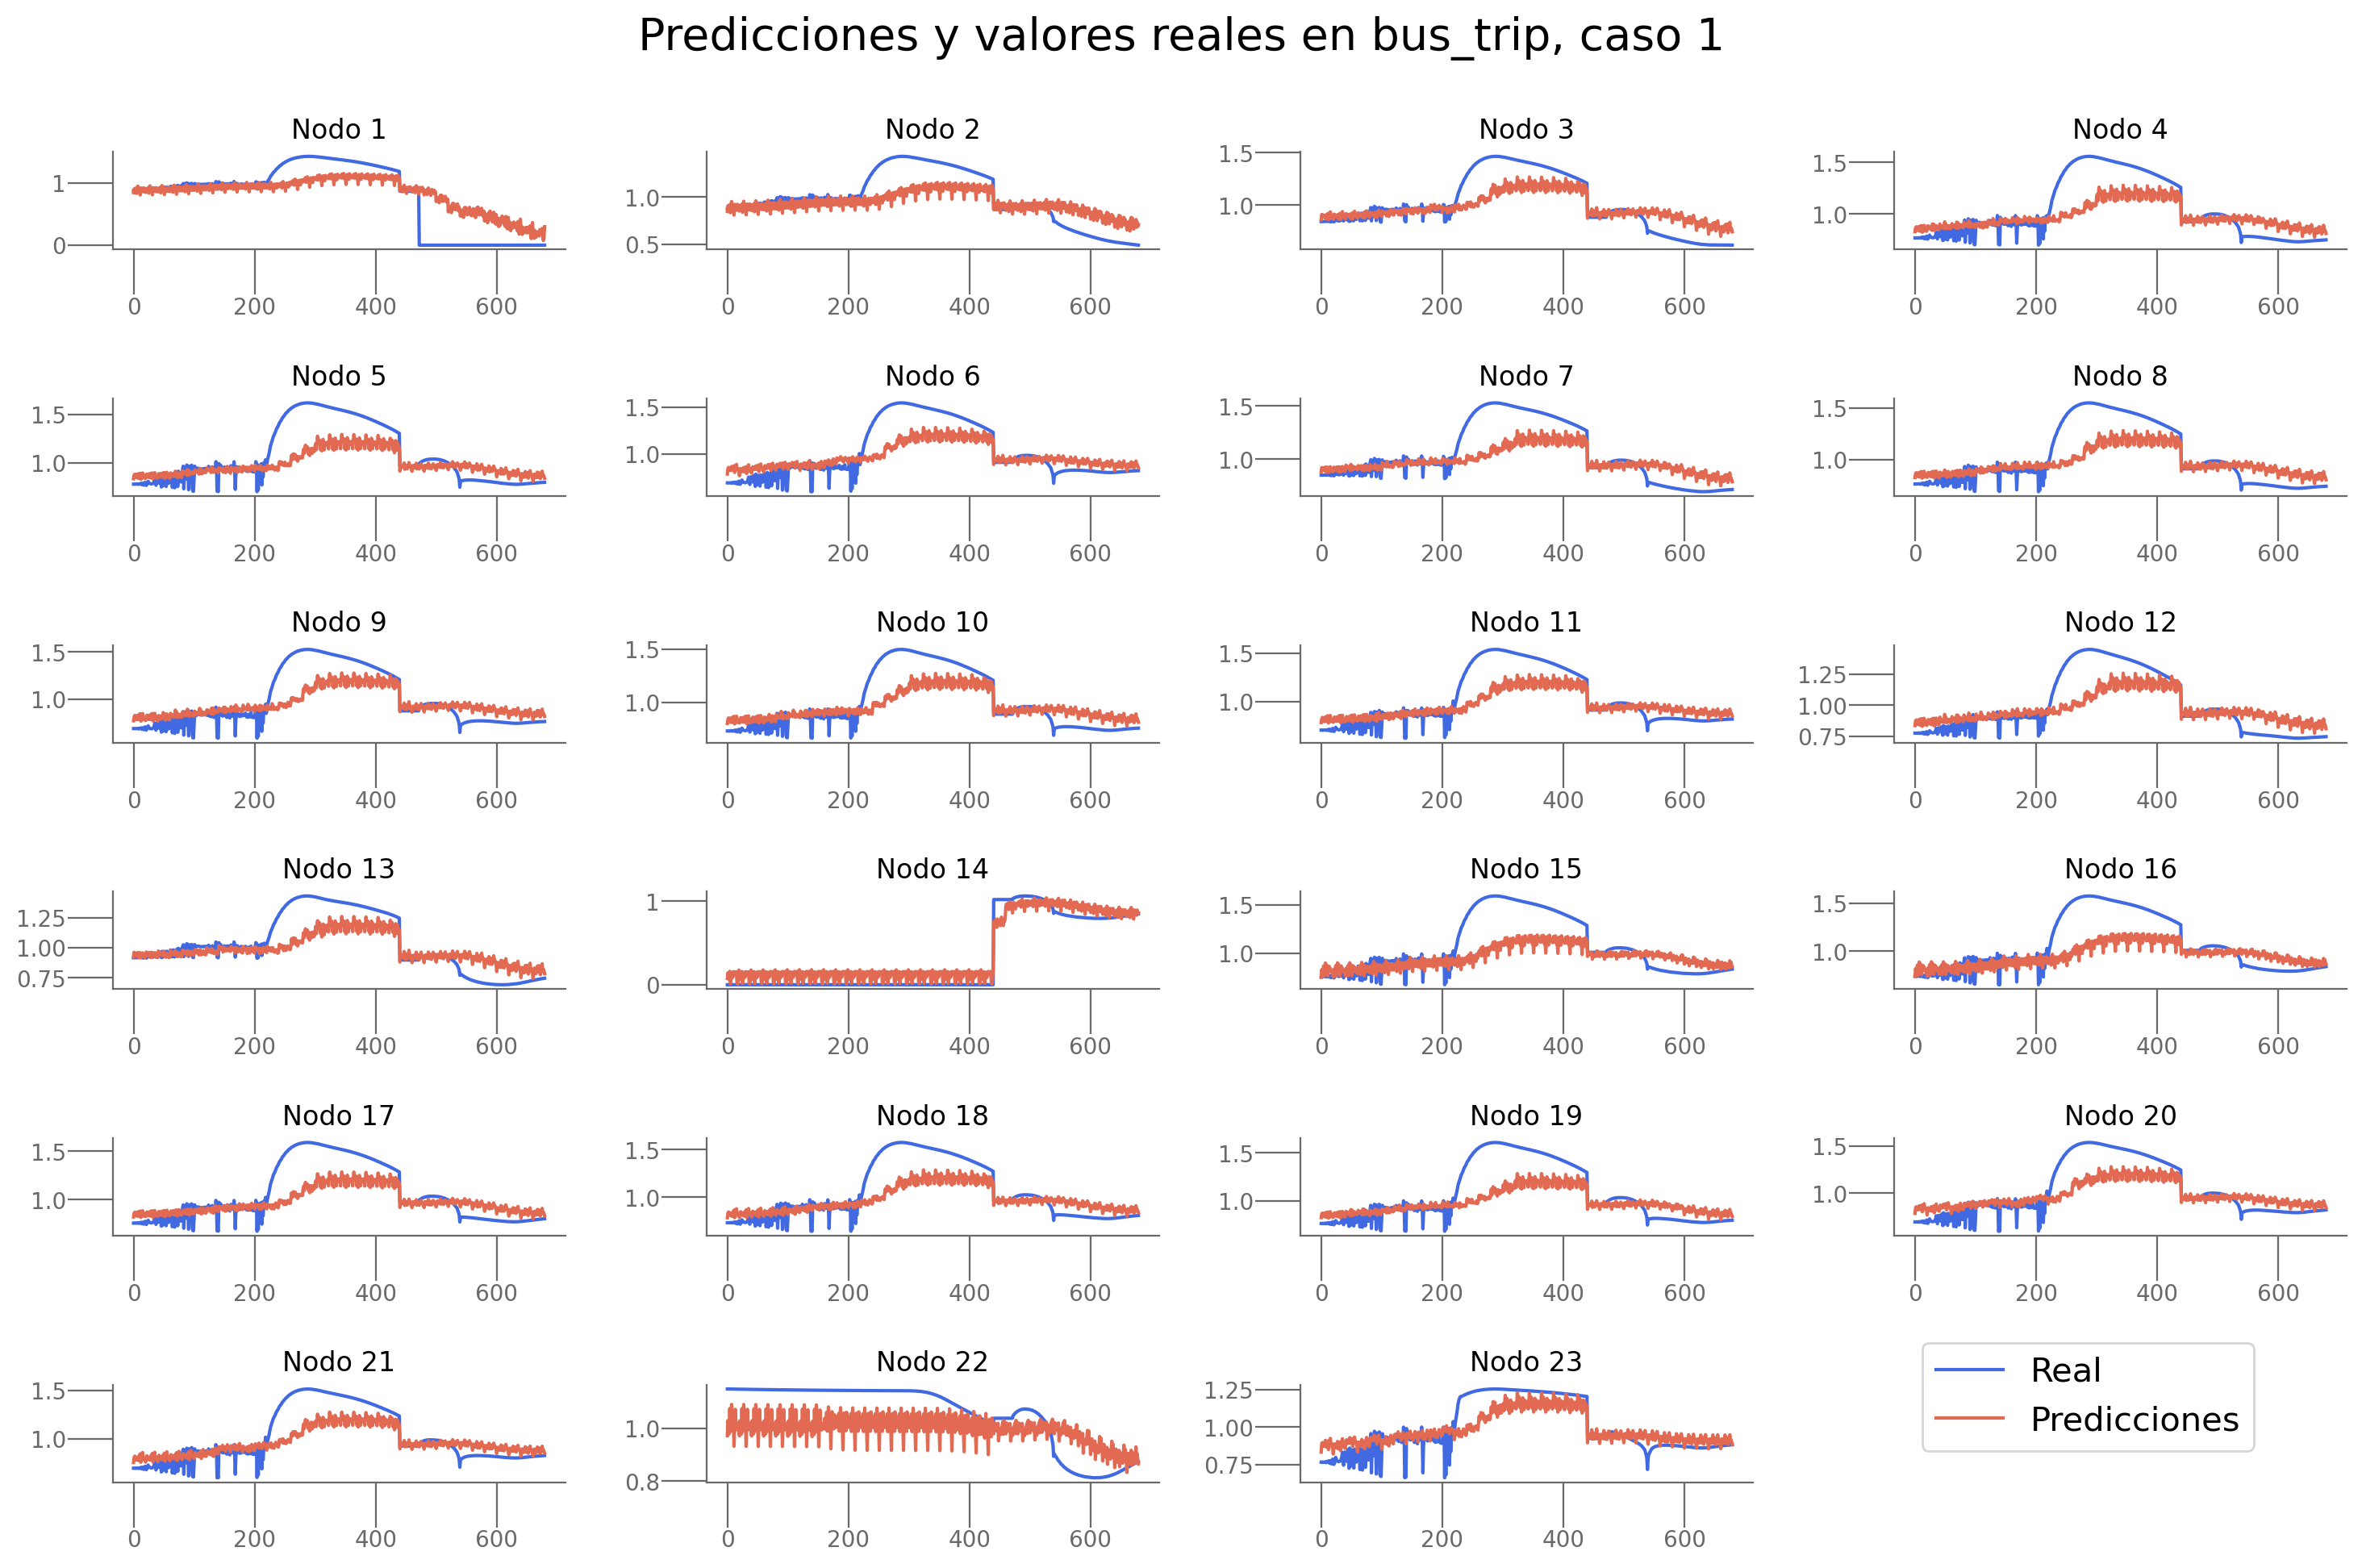

In [54]:
plot_predictions(predictions_bt, real_bt, n_target, 1, n_div_bt, problem)

#### Ajuste de parámetros 

In [88]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

modelo_bt,params_bt, resultados_bt, h = entrenar_y_evaluar_modelos(param_grid, n_features, n_nodes, n_target, dataloader_bt, num_early_stop, num_epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]


==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0310 | Eval Loss: 0.4407 | Eval R2: -13.0006 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4496 | Eval Loss: 0.1505 | Eval R2: -3.6241 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1544 | Eval Loss: 0.1431 | Eval R2: -3.9599 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1482 | Eval Loss: 0.0965 | Eval R2: -2.2159 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1021 | Eval Loss: 0.0706 | Eval R2: -0.9824 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0737 | Eval Loss: 0.0821 | Eval R2: -1.2038 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0837 | Eval Loss: 0.0917 | Eval R2: -1.5102 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0927 | Eval Loss: 0.0835 | Eval R2: -1.2585 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0843 | Eval Loss: 0.0814 | Eval R2: -1.1909 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0823 | Eval Loss: 0.0784 | Eval R2: -1.0889 | LR: 0.001000
Epoch 11/30 | Train Loss: 0.0794 | Eval Loss: 0.0749 | Eval R2: -0.9739 | LR: 0.0010

 12%|█▎        | 1/8 [07:31<52:39, 451.34s/it]

Test_loss:0.0408, Test_r2:-0.0245
Parámetros:  add 1 1
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.0401303730905056, 'r2_eval_final': 0.0785214325008463, 'loss_eval_final': 0.03846677575693948, 'r2_test': -0.02454359808217538, 'loss_test': 0.04081780659711681}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0743 | Eval Loss: 0.7778 | Eval R2: -25.3580 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7718 | Eval Loss: 0.1692 | Eval R2: -3.7638 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1730 | Eval Loss: 0.1793 | Eval R2: -4.8294 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1884 | Eval Loss: 0.1478 | Eval R2: -3.5723 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1566 | Eval Loss: 0.1059 | Eval R2: -1.7874 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.1128 | Eval Loss: 0.1069 | Eval R2: -1.6269 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1123 | Eval Loss: 0.1268 | Eval R2: -2.2480 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.1309 | Eval Loss: 0.1259 | Eval 

 25%|██▌       | 2/8 [16:25<49:59, 499.92s/it]

Test_loss:0.0694, Test_r2:-0.8948
Parámetros:  add 1 2
Resultados:  {'Aggr': 'add', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.06809697300195694, 'r2_eval_final': -0.6399932056332741, 'loss_eval_final': 0.06427247418979204, 'r2_test': -0.8948410492512988, 'loss_test': 0.06935387824277589}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0549 | Eval Loss: 0.6499 | Eval R2: -20.6562 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6559 | Eval Loss: 0.1605 | Eval R2: -3.9380 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1659 | Eval Loss: 0.1258 | Eval R2: -3.0541 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1298 | Eval Loss: 0.0720 | Eval R2: -0.7251 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0739 | Eval Loss: 0.0946 | Eval R2: -1.5063 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0907 | Eval Loss: 0.0844 | Eval R2: -1.2578 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0817 | Eval Loss: 0.0770 | Eval R2: -1.1565 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0762 | Eval Loss: 0.0743 | Eval

 38%|███▊      | 3/8 [28:14<49:37, 595.42s/it]

Parámetros:  add 2 1
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.029785925522446632, 'r2_eval_final': 0.11721373508083288, 'loss_eval_final': 0.03370264150930204, 'r2_test': 0.15898958678834102, 'loss_test': 0.031790854596684494}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0309 | Eval Loss: 0.7337 | Eval R2: -23.6639 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7381 | Eval Loss: 0.1727 | Eval R2: -4.0062 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1788 | Eval Loss: 0.1396 | Eval R2: -3.2189 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1473 | Eval Loss: 0.0983 | Eval R2: -1.4212 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1046 | Eval Loss: 0.1150 | Eval R2: -1.8116 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.1196 | Eval Loss: 0.1285 | Eval R2: -2.2635 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1325 | Eval Loss: 0.1163 | Eval R2: -1.8918 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.1205 | Eval Loss: 0.1141 | Eval R2: -1.8258 | LR: 0.001000
Epoc

 50%|█████     | 4/8 [42:14<46:08, 692.09s/it]

Test_loss:0.0612, Test_r2:-0.4259
Parámetros:  add 2 2
Resultados:  {'Aggr': 'add', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.06196774169802666, 'r2_eval_final': -0.37151531190995724, 'loss_eval_final': 0.060504549617568654, 'r2_test': -0.4258666328433943, 'loss_test': 0.061244798243738886}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0083 | Eval Loss: 0.4409 | Eval R2: -13.1921 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.4517 | Eval Loss: 0.1426 | Eval R2: -3.8698 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1479 | Eval Loss: 0.1579 | Eval R2: -4.7481 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1672 | Eval Loss: 0.0732 | Eval R2: -1.1837 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0812 | Eval Loss: 0.0776 | Eval R2: -1.0061 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0792 | Eval Loss: 0.1006 | Eval R2: -1.7361 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0989 | Eval Loss: 0.0938 | Eval R2: -1.5302 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0915 | Eval Loss: 0.0909 | E

 62%|██████▎   | 5/8 [51:31<32:10, 643.38s/it]

Test_loss:0.0401, Test_r2:-0.0195
Parámetros:  mean 1 1
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 1, 'loss_final': 0.03909316658973694, 'r2_eval_final': 0.06098270386920489, 'loss_eval_final': 0.03833259732152025, 'r2_test': -0.019520557382921126, 'loss_test': 0.040099027268263664}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0228 | Eval Loss: 0.7636 | Eval R2: -24.9035 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7590 | Eval Loss: 0.1922 | Eval R2: -4.5620 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1942 | Eval Loss: 0.2135 | Eval R2: -6.0677 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.2229 | Eval Loss: 0.1756 | Eval R2: -4.7229 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1849 | Eval Loss: 0.1019 | Eval R2: -1.6758 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.1091 | Eval Loss: 0.0981 | Eval R2: -1.2643 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1037 | Eval Loss: 0.1238 | Eval R2: -2.0557 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.1283 | Eval Loss: 0.1319 |

 75%|███████▌  | 6/8 [1:03:28<22:16, 668.21s/it]

Test_loss:0.0703, Test_r2:-1.0150
Parámetros:  mean 1 2
Resultados:  {'Aggr': 'mean', 'Conv': 1, 'LSTM': 2, 'loss_final': 0.06656148284673691, 'r2_eval_final': -0.773412007888316, 'loss_eval_final': 0.06473702848407215, 'r2_test': -1.0150106232052103, 'loss_test': 0.07028640164495555}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0591 | Eval Loss: 0.6301 | Eval R2: -19.8371 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.6370 | Eval Loss: 0.1389 | Eval R2: -3.5910 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1434 | Eval Loss: 0.0924 | Eval R2: -1.7753 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.0959 | Eval Loss: 0.0837 | Eval R2: -1.0635 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0832 | Eval Loss: 0.0889 | Eval R2: -1.2218 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0857 | Eval Loss: 0.0669 | Eval R2: -0.6410 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0653 | Eval Loss: 0.0553 | Eval R2: -0.4872 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0547 | Eval Loss: 0.0454 | Eva

 88%|████████▊ | 7/8 [1:22:11<13:37, 817.00s/it]

Parámetros:  mean 2 1
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 1, 'loss_final': 0.012839787639677525, 'r2_eval_final': 0.618112799451379, 'loss_eval_final': 0.013697172891905253, 'r2_test': 0.6060303598116376, 'loss_test': 0.014110390340833556}

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 1.0034 | Eval Loss: 0.7295 | Eval R2: -23.3896 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.7267 | Eval Loss: 0.1756 | Eval R2: -4.0627 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1846 | Eval Loss: 0.1207 | Eval R2: -2.3671 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1296 | Eval Loss: 0.0994 | Eval R2: -1.2911 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1050 | Eval Loss: 0.1223 | Eval R2: -2.0674 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.1261 | Eval Loss: 0.1229 | Eval R2: -2.1619 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.1265 | Eval Loss: 0.1105 | Eval R2: -1.8115 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.1144 | Eval Loss: 0.1087 | Eval R2: -1.7531 | LR: 0.001000
Epoc

100%|██████████| 8/8 [1:42:11<00:00, 766.43s/it]

Test_loss:0.0613, Test_r2:-0.4754
Parámetros:  mean 2 2
Resultados:  {'Aggr': 'mean', 'Conv': 2, 'LSTM': 2, 'loss_final': 0.06201505661010742, 'r2_eval_final': -0.3345920890930249, 'loss_eval_final': 0.059464178130501644, 'r2_test': -0.4753621201190974, 'loss_test': 0.061326434307320175}


In [99]:
losses_tst, r2score_tst, loss_nodes_bt, predictions_bt_ajuste, real_bt_ajuste = test(modelo_bt, dataloader_bt, modelo_bt.h)



==================== TEST INFO ===================

Test_loss:0.0141, Test_r2:0.6060


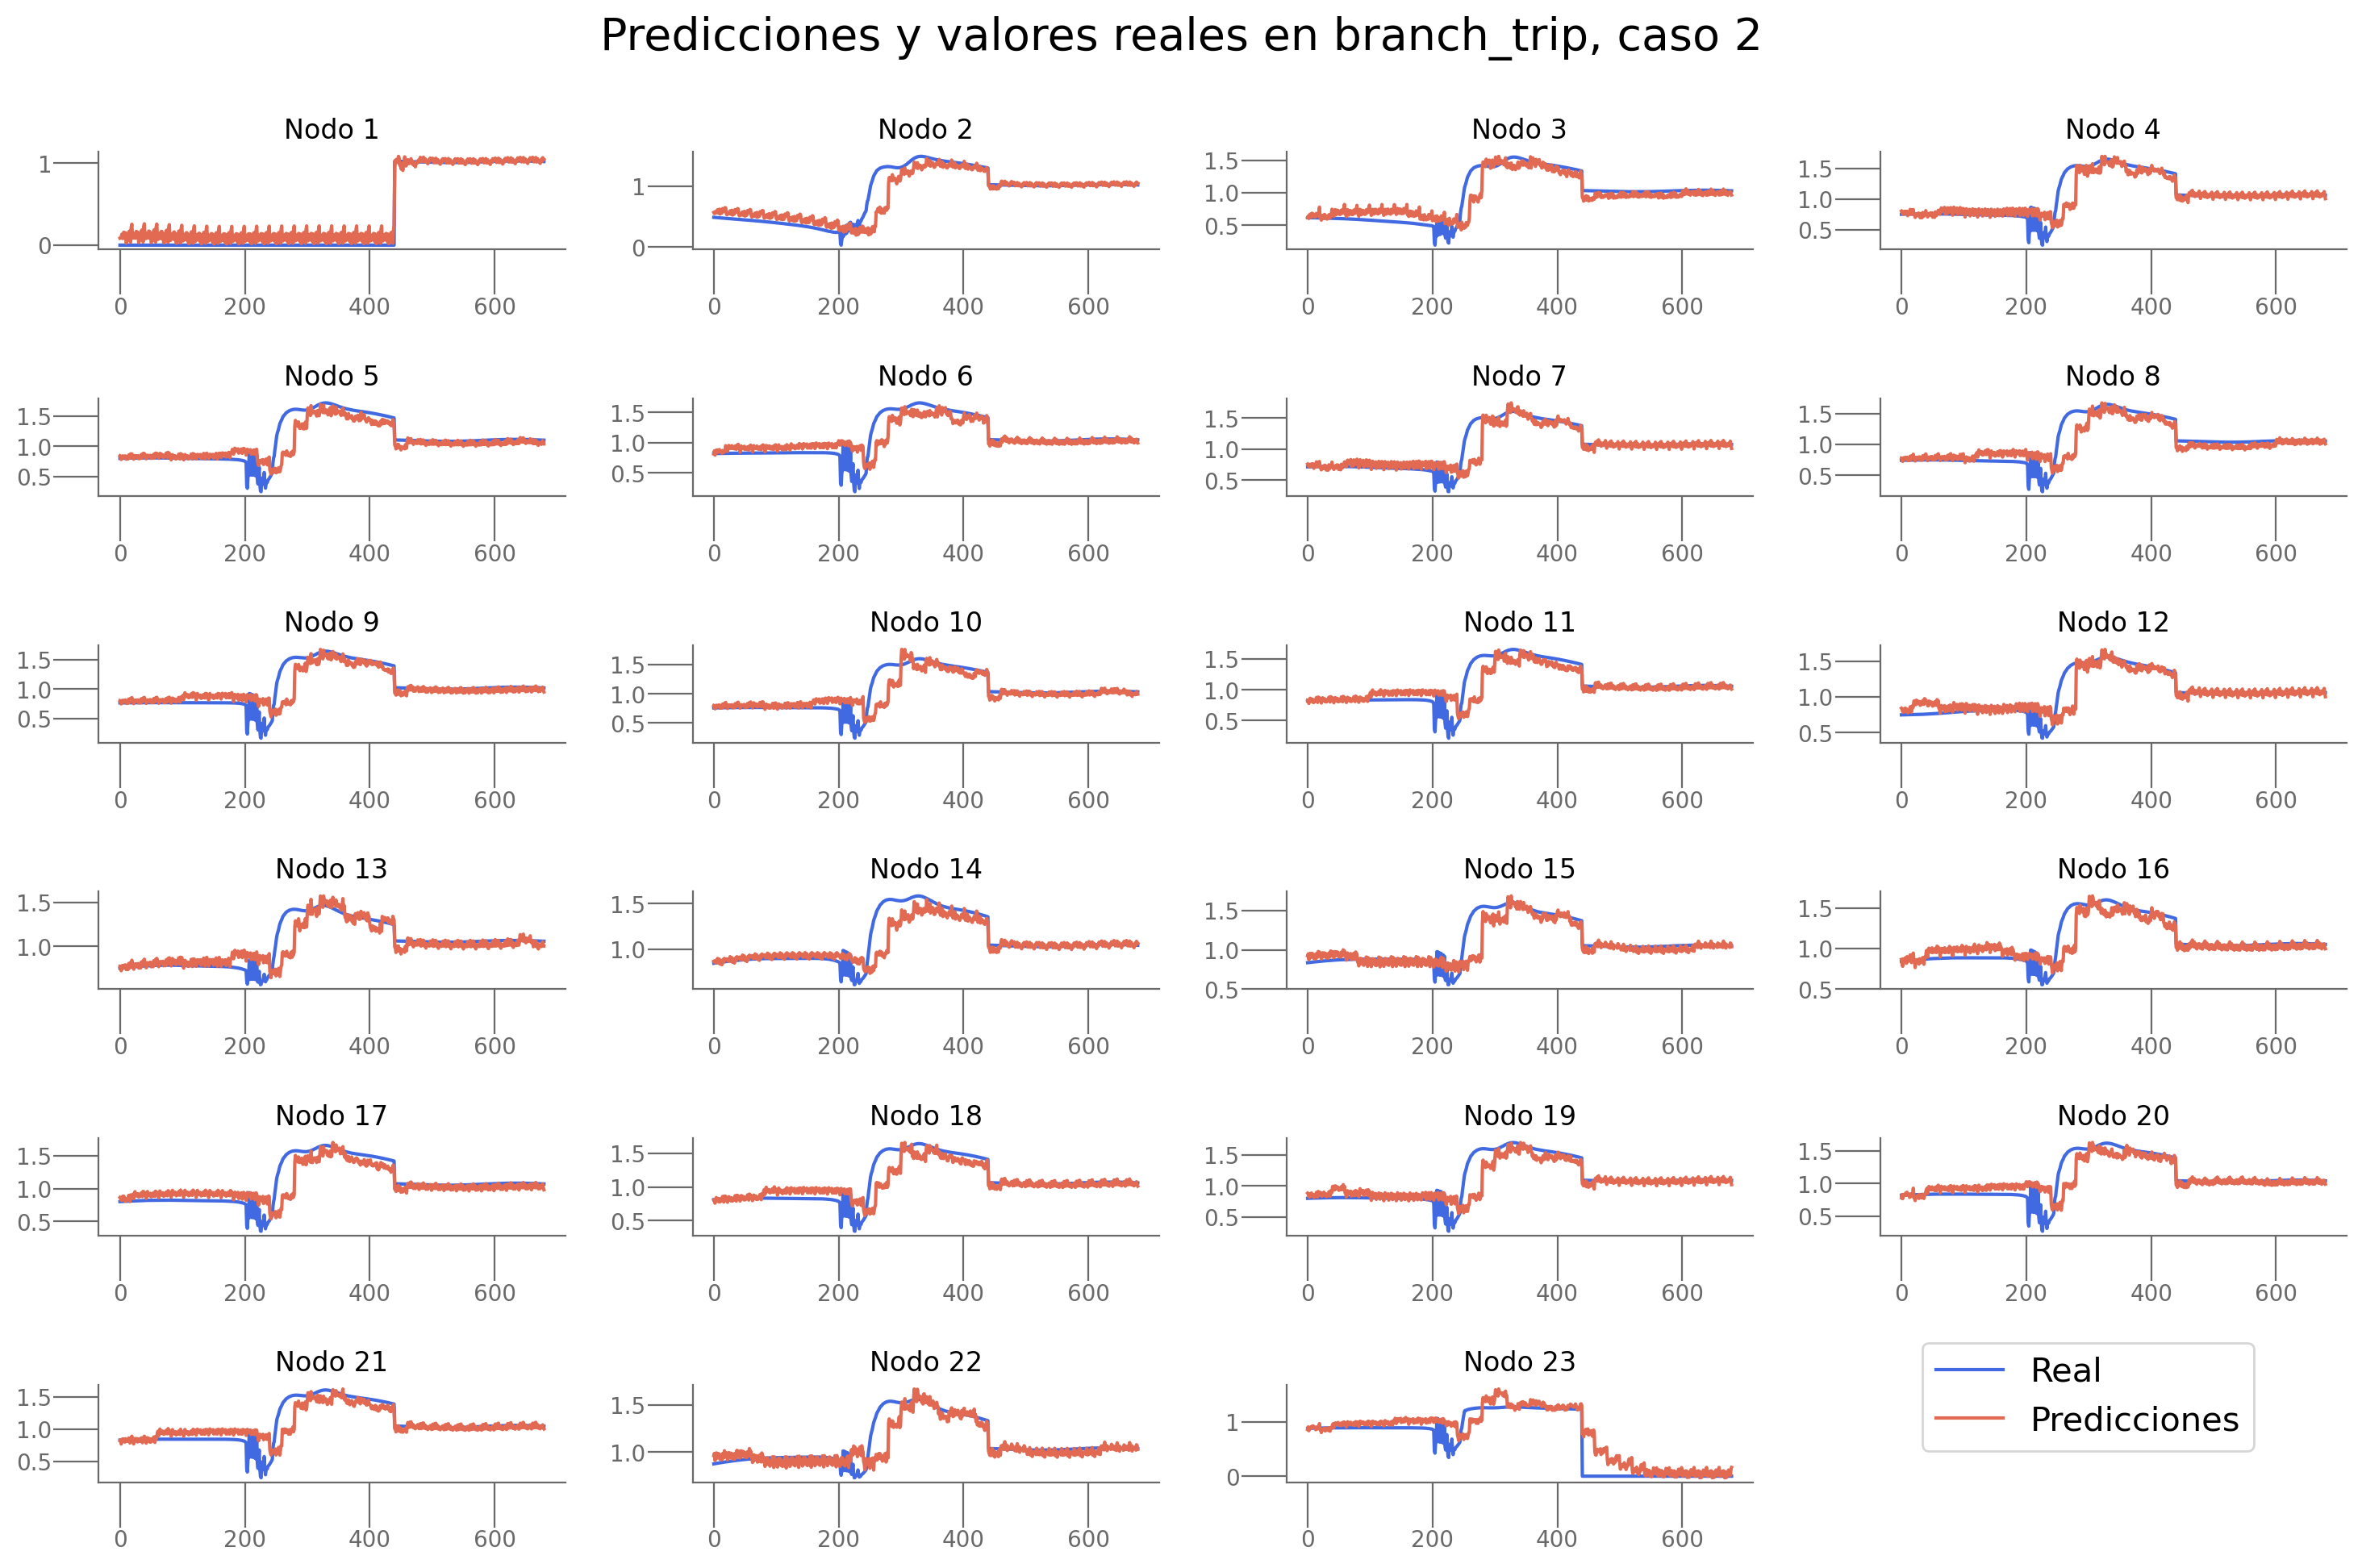

In [102]:
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 2, n_div_gt, problem)

### Bus fault

In [55]:
problem = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [56]:
n_div_bf = loader.div

#### Sencilla 

In [57]:
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

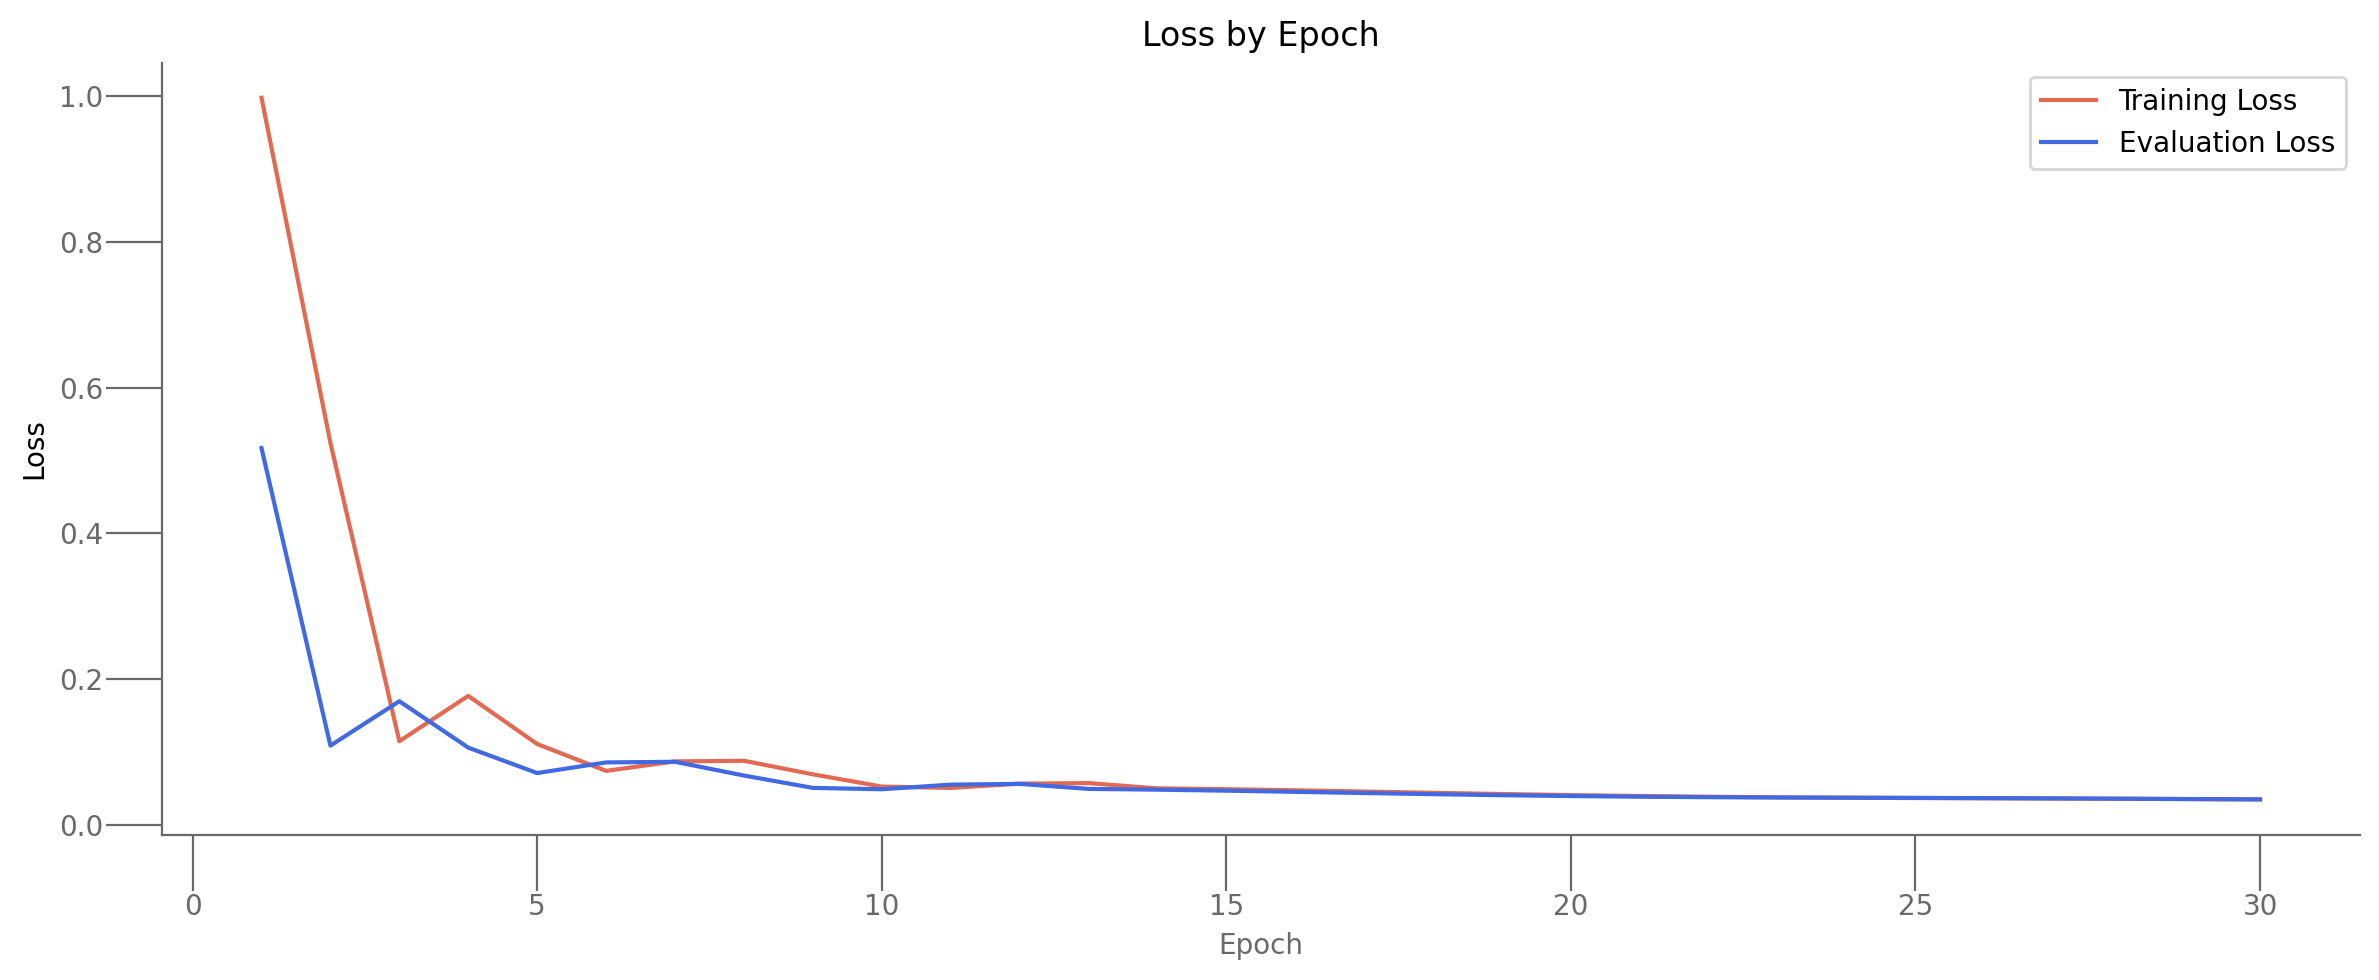


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [58]:

dataloader_bf = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_bf = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")

num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_bf, dataloader_bf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes_bf, predictions_bf, real_bf = test(model_bf, dataloader_bf, h)


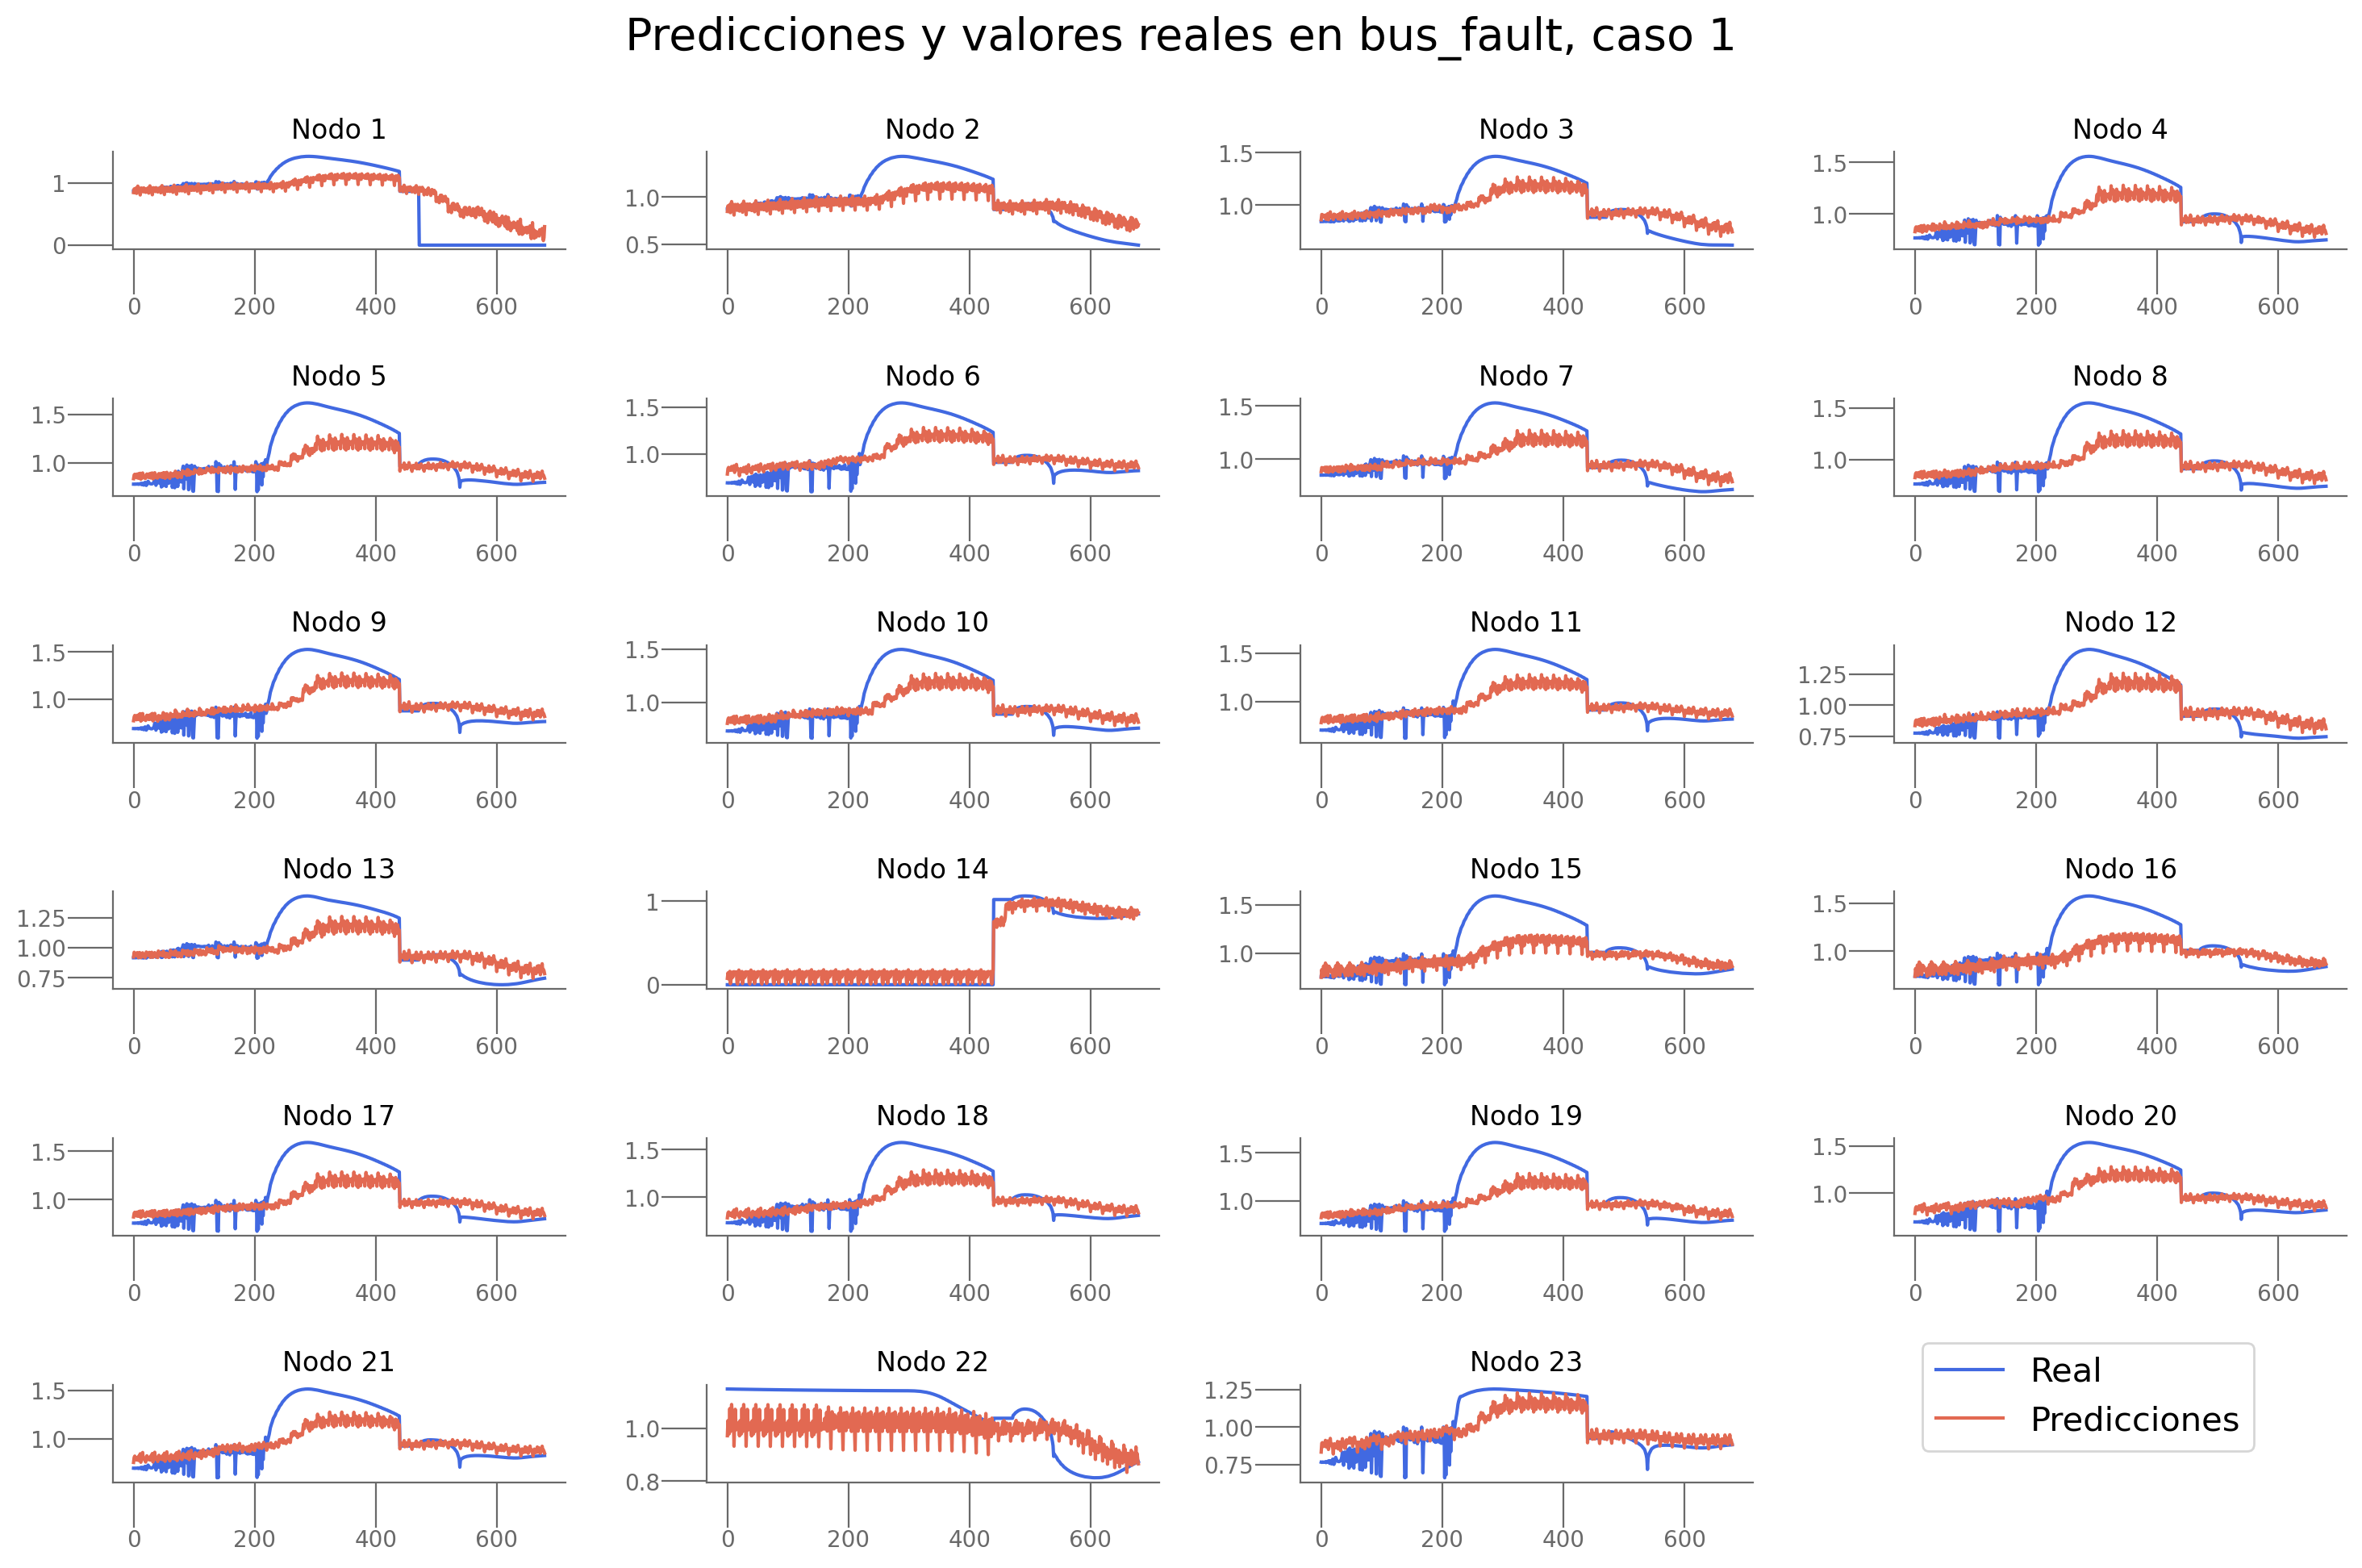

In [59]:
plot_predictions(predictions_bf, real_bf, n_target, 1,n_div_bf, problem)

### Branch Fault

In [60]:
problem = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [61]:
n_div_brf = loader.div

#### Sencilla 

In [62]:
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

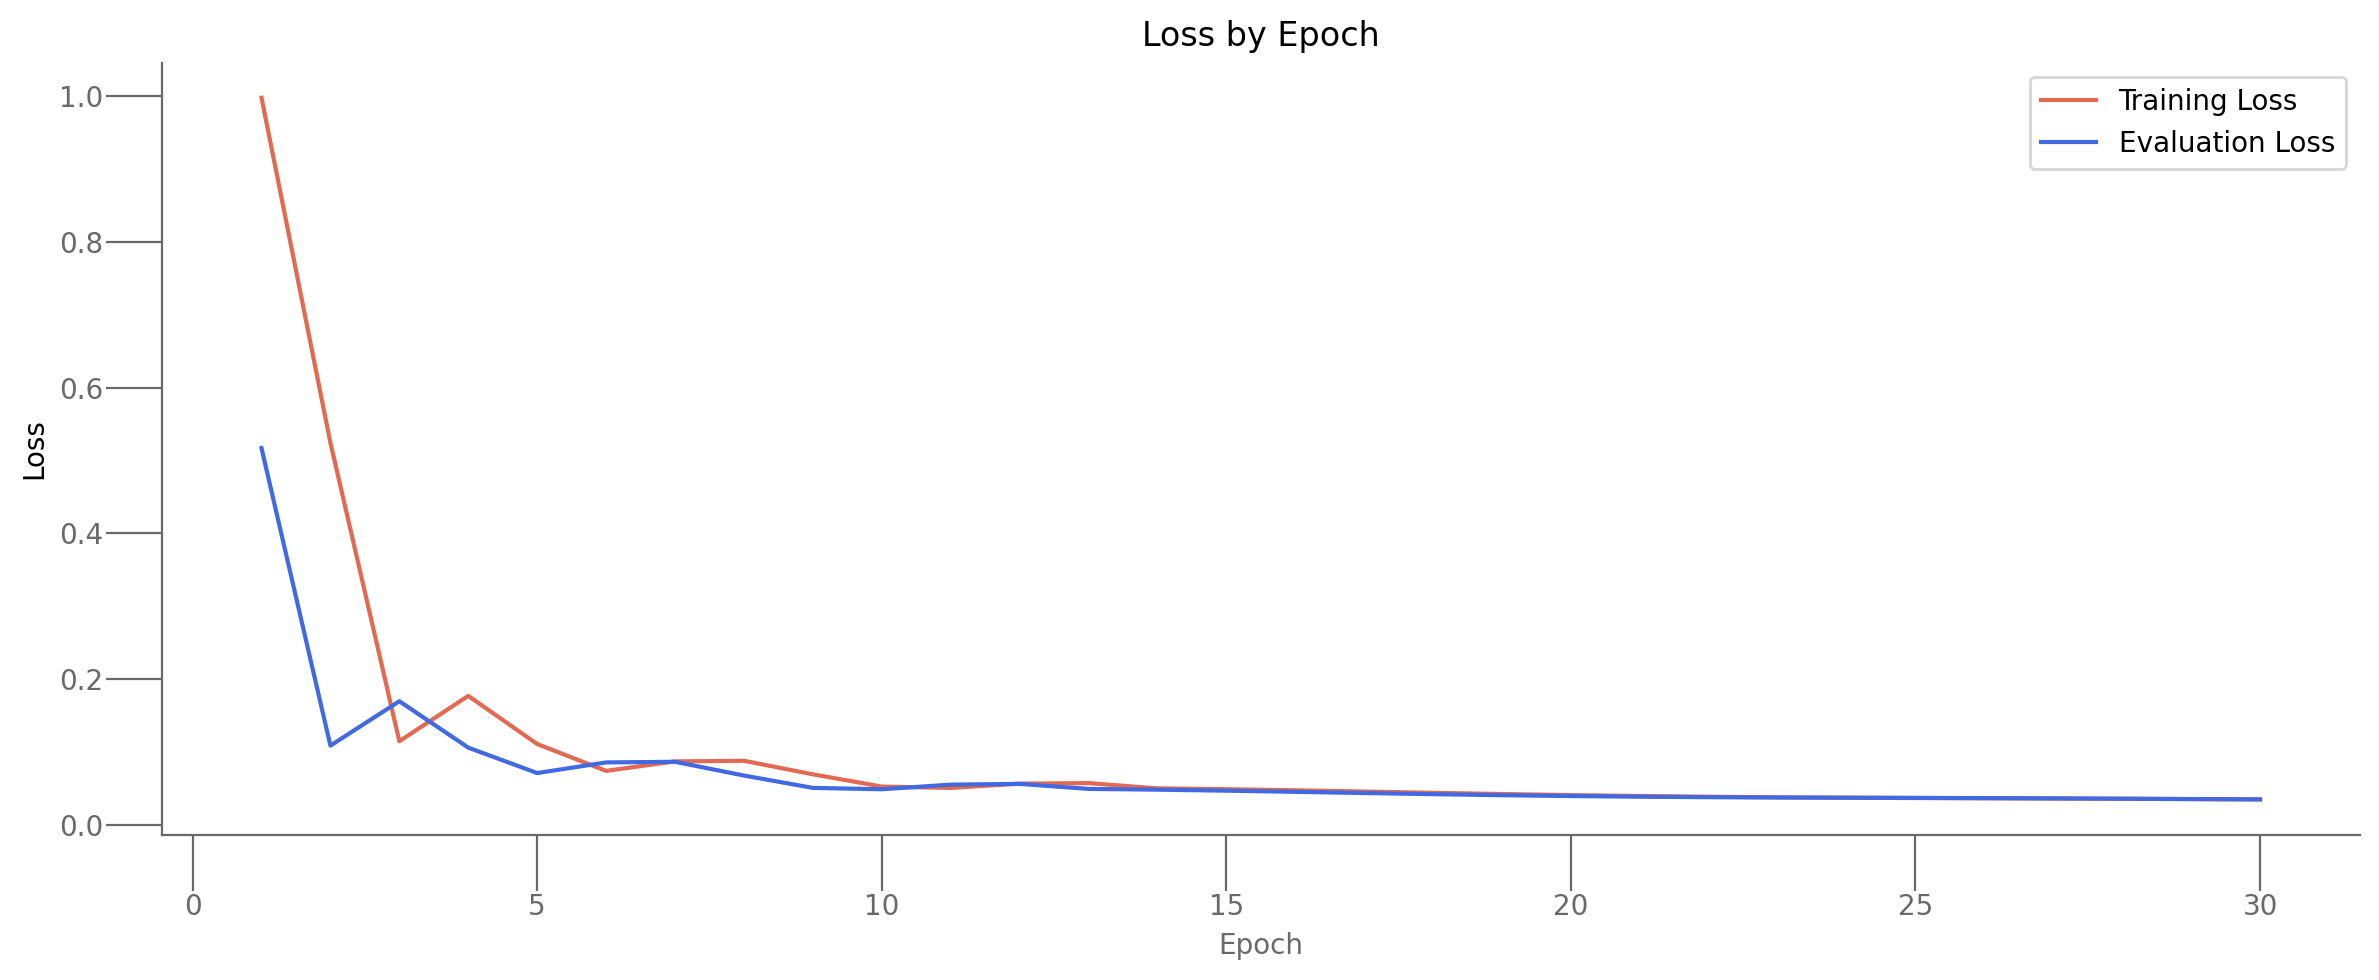


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [63]:
dataloader_brf = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_brf = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")


num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_brf, dataloader_brf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes_brf, predictions_brf, real_brf = test(model_brf, dataloader_brf, h)


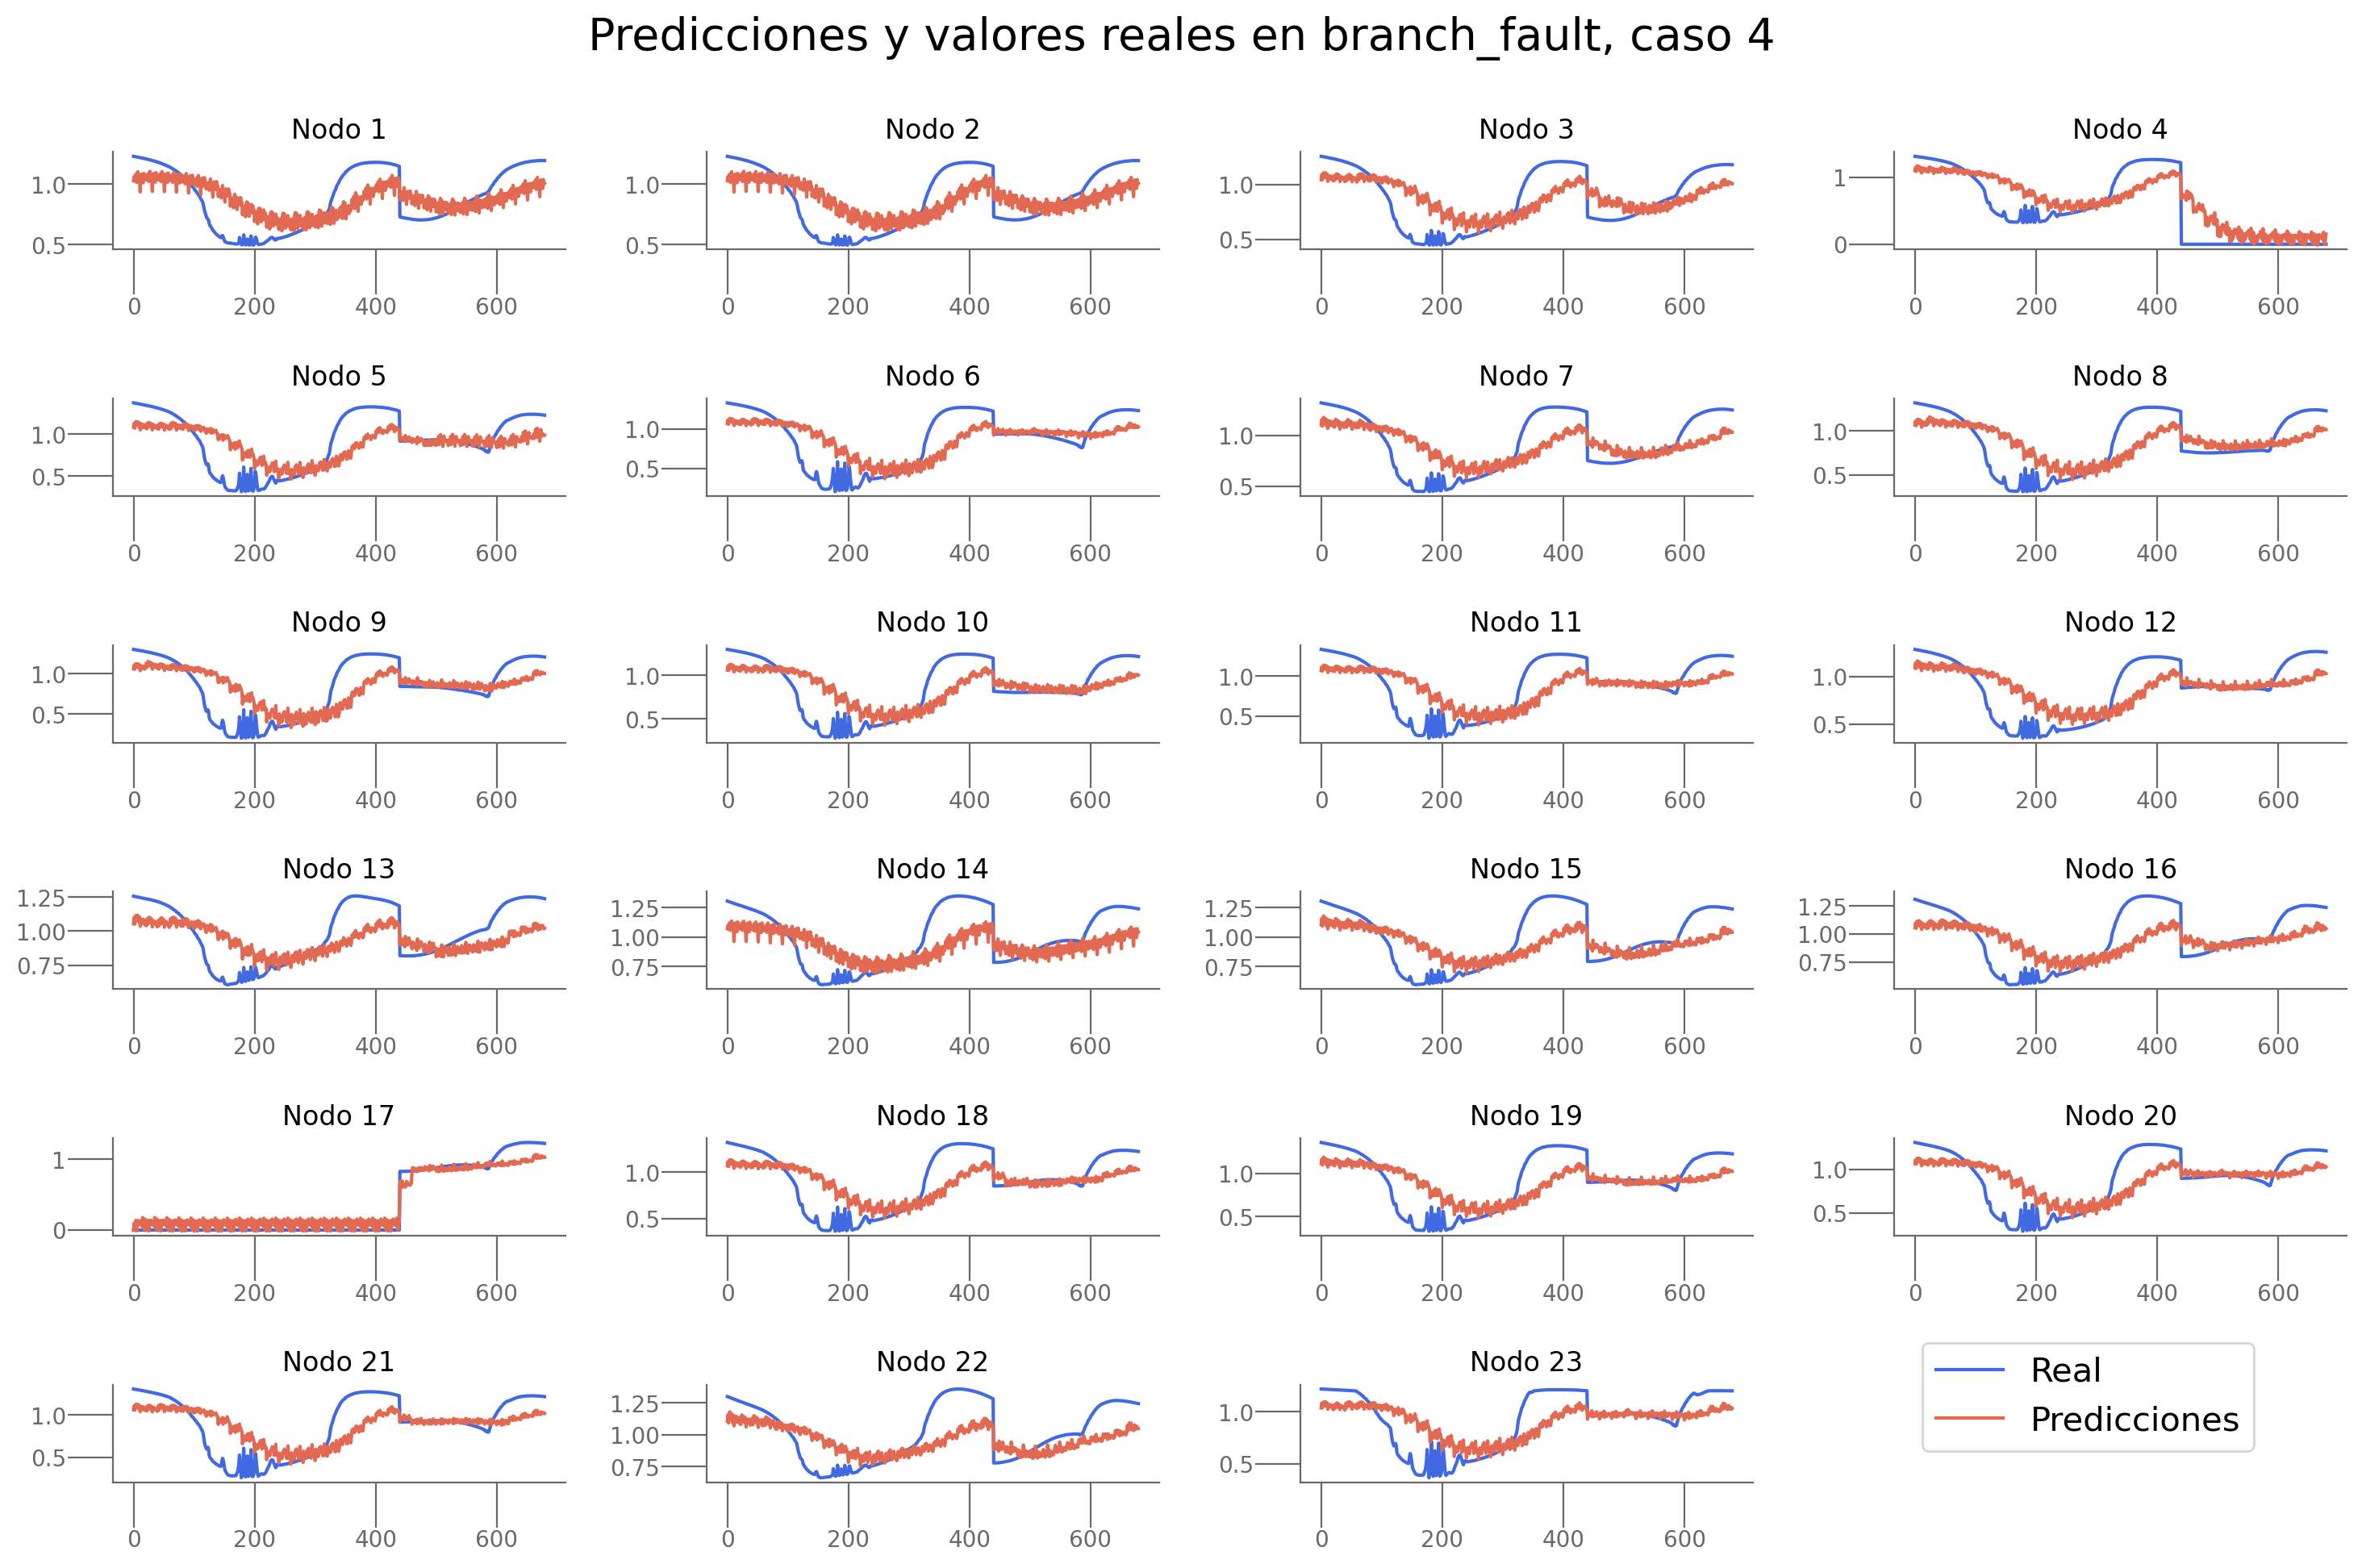

In [64]:
plot_predictions(predictions_brf, real_brf, n_target, 4,  n_div_brf, problem)

### Branch trip

In [65]:
problem = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [66]:
n_div_brt = loader.div

#### Sencilla 

In [67]:
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.9978 | Eval Loss: 0.5170 | Eval R2: -15.8552 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.5244 | Eval Loss: 0.1089 | Eval R2: -2.0374 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.1149 | Eval Loss: 0.1698 | Eval R2: -5.1089 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.1771 | Eval Loss: 0.1061 | Eval R2: -2.5601 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.1111 | Eval Loss: 0.0712 | Eval R2: -0.8616 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0742 | Eval Loss: 0.0858 | Eval R2: -1.1448 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0872 | Eval Loss: 0.0867 | Eval R2: -1.1407 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0881 | Eval Loss: 0.0678 | Eval R2: -0.5723 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0695 | Eval Loss: 0.0509 | Eval R2: -0.1620 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0527 | Eval Loss: 0.0490 

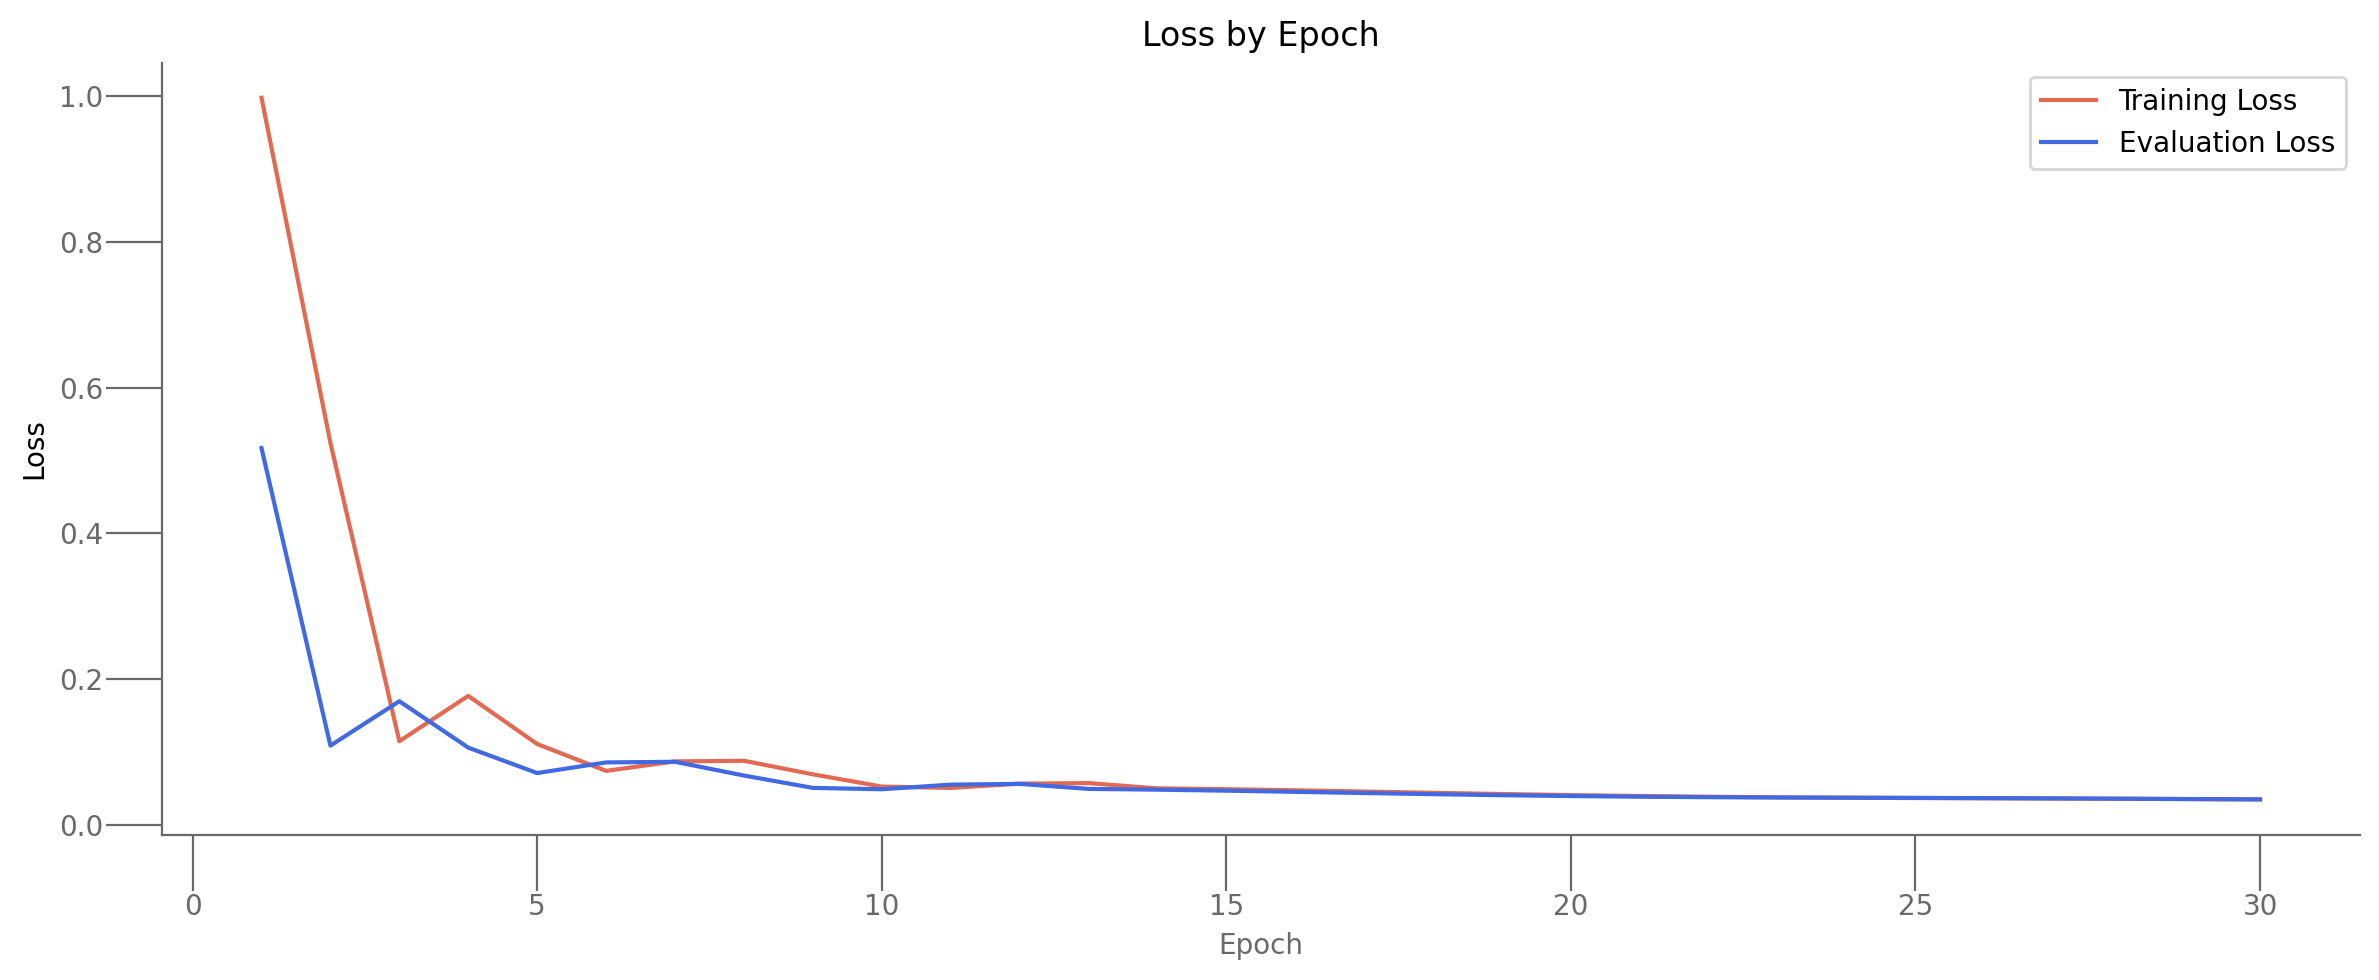


==================== TEST INFO ===================

Test_loss:0.0375, Test_r2:0.1548


In [68]:

dataloader_brt = trainer.train_test_val_split(dataset_bt, 
                                          batch_size=dataloader_params2["batch_size"], 
                                          data_split_ratio=dataloader_params2["data_split_ratio"], 
                                          random_seed=dataloader_params2["seed"], 
                                          keep_same=dataloader_params2["keep_same"], 
                                          use_batch=dataloader_params2["use_batch"])
model_brt = RecurrentGCN("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, aggr="add")

num_early_stop = 0
num_epochs = 30
lr = 0.01
losses,eval_losses, r2scores, h = train(model_brt, dataloader_brt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes_brt, predictions_brt, real_brt = test(model_brt, dataloader_brt, h)


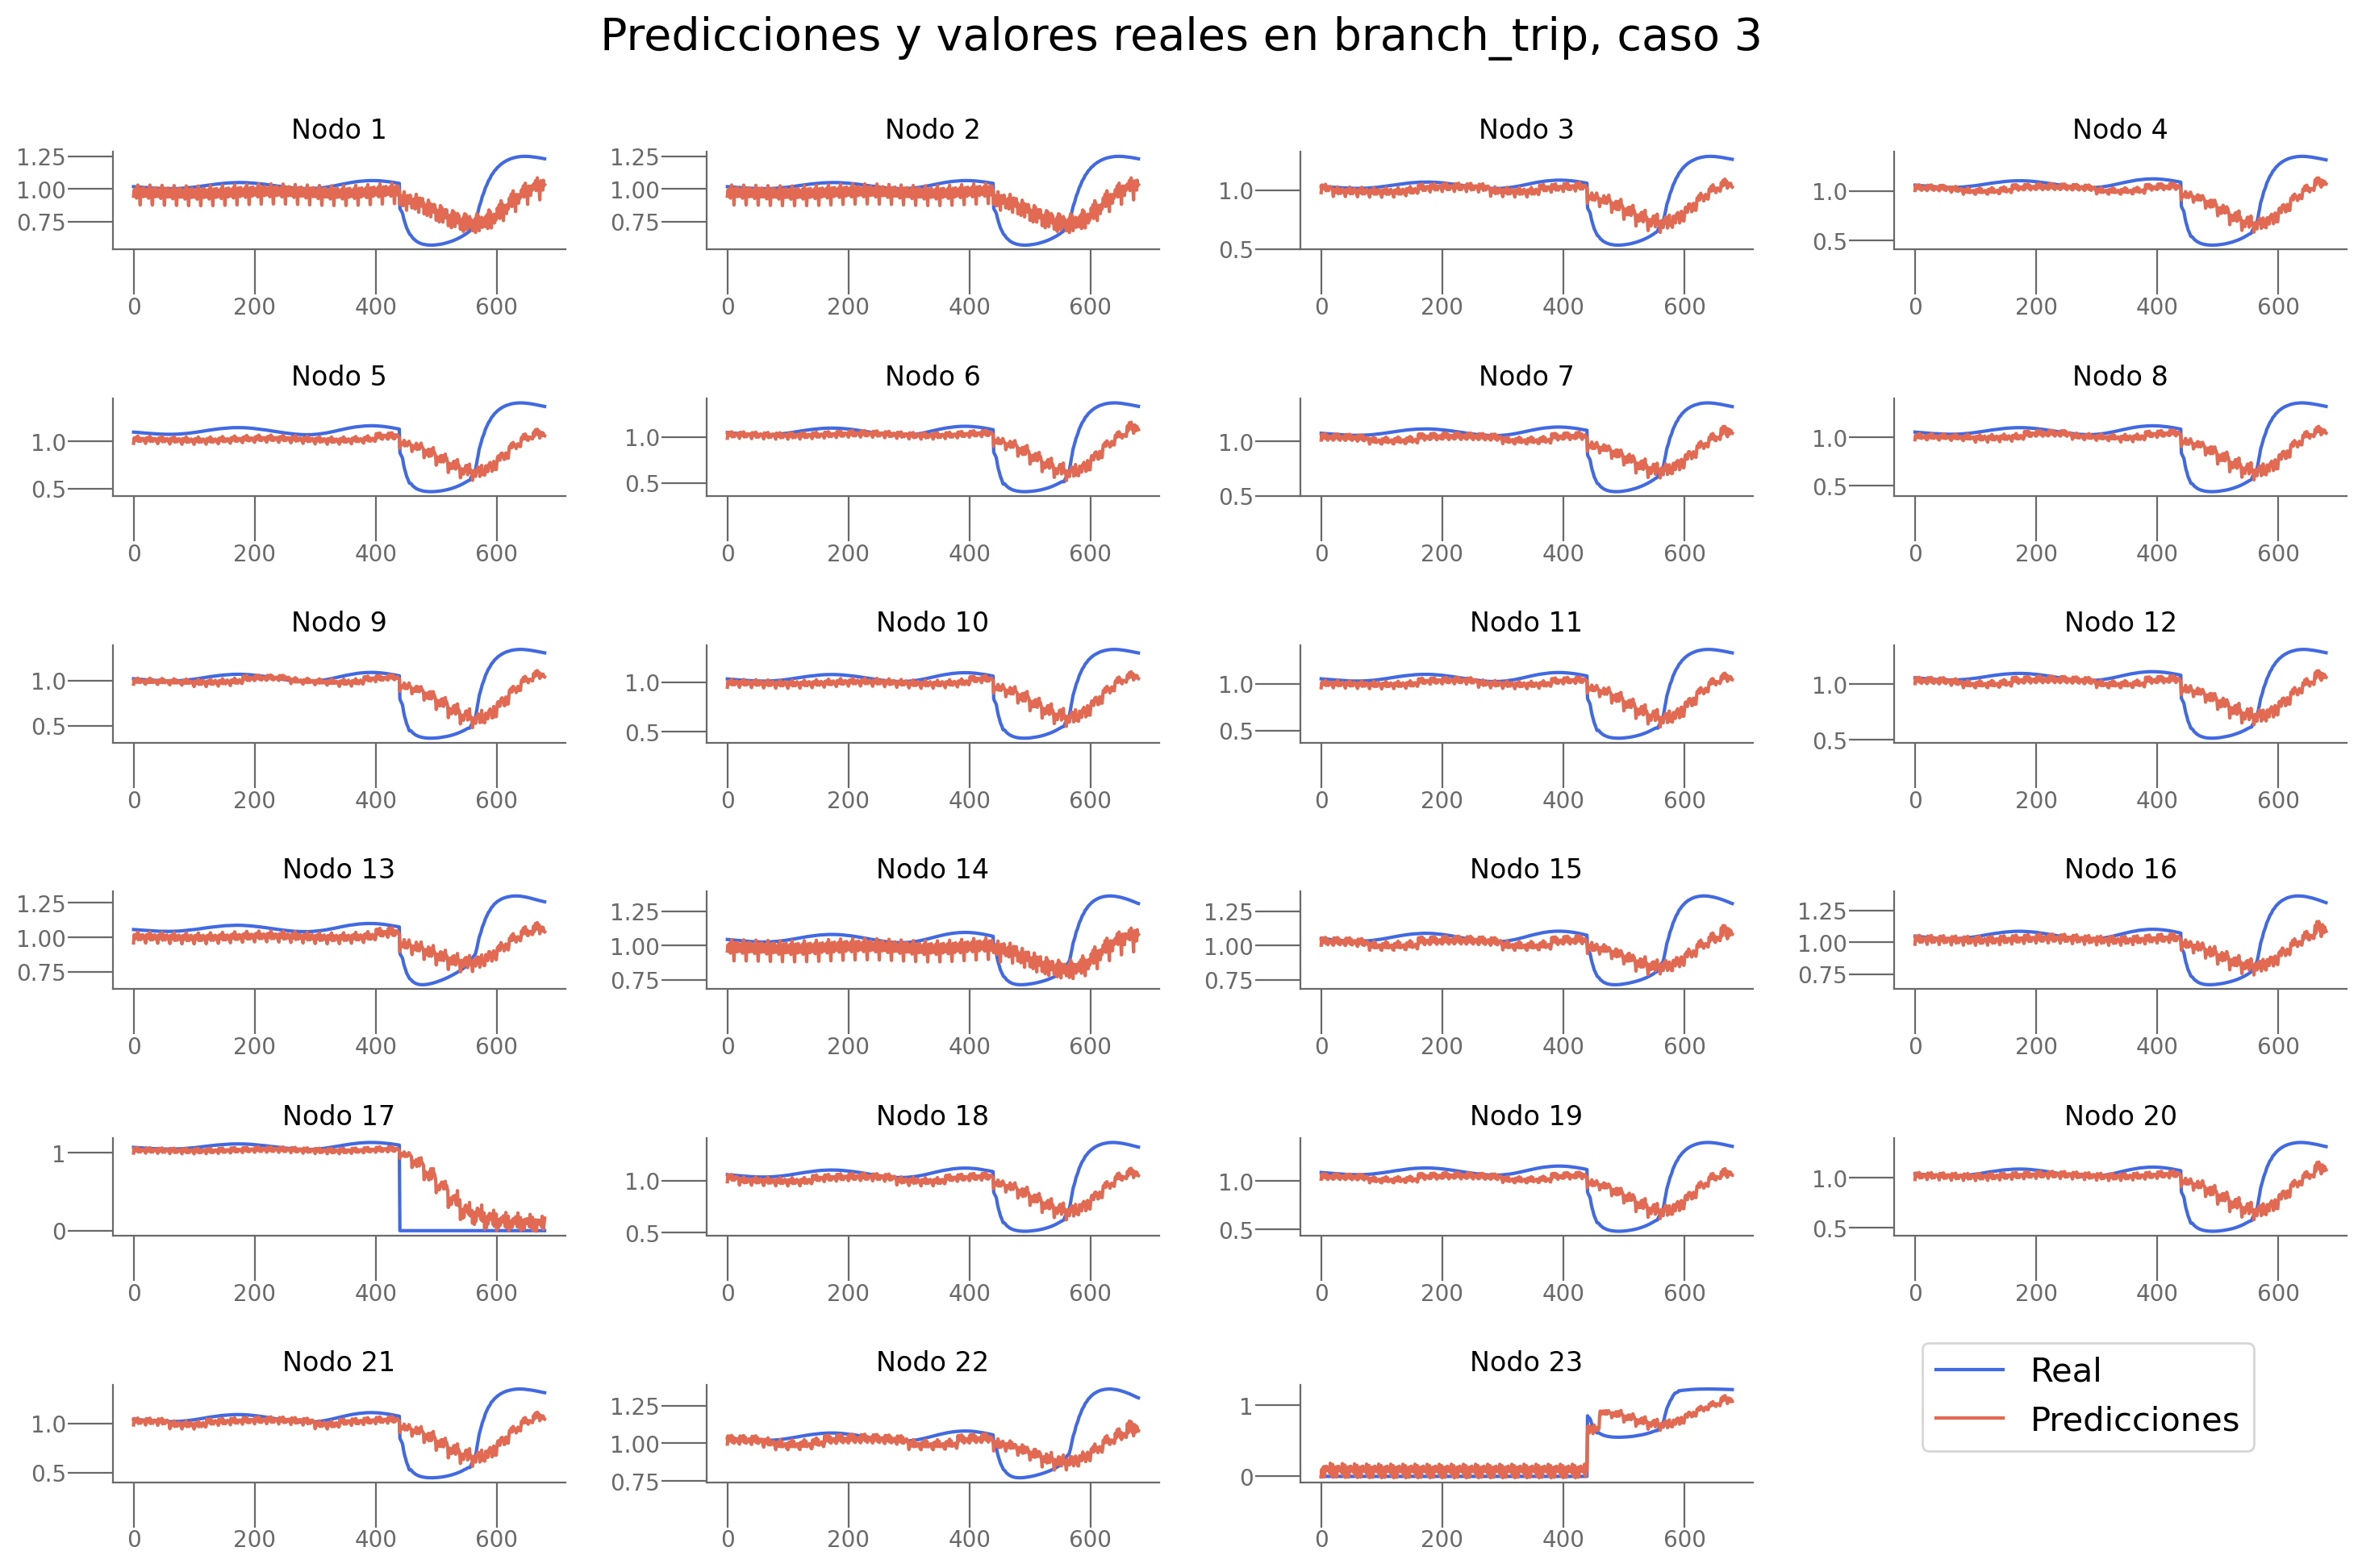

In [69]:
plot_predictions(predictions_brt, real_brt, n_target, 3, n_div_brt, problem)